In [40]:
# %% [markdown]
# # Reflection NER — 모델×데이터셋 성능/오류 분석
# 1) JSONL 로딩 → per-sample 성능 테이블
# 2) 오류 유형 5가지 집계 (Boundary / Type / Boundary+Type / FP / FN)
# 3) 모델×데이터셋 성능 집계 (Micro/Macro) + 평균/표준편차 + 에러밴드 시각화

# === 기본 ===
import os, re, glob, json, math
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

# === 수치/테이블 ===
import numpy as np
import pandas as pd

# === 시각화 ===
import matplotlib.pyplot as plt

# === 통계 (유의성 검정 등) ===
from scipy import stats

# === 경고/시드 ===
import warnings
warnings.filterwarnings("ignore")

# === Matplotlib 기본 스타일(논문용 약간 단정하게) ===
plt.rcParams["figure.figsize"] = (7.2, 4.2)
plt.rcParams["font.size"] = 11
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.alpha"] = 0.4

# === 공통 경로(필요시 수정) ===
RUNS_ROOT = Path("./runs_ffinal/preds")  # 여러 timestamp 디렉토리가 있는 상위 경로

# === 모델/데이터셋 표준 이름 매핑(플롯 라벨 깔끔하게) ===
MODEL_PRETTY = {
    "openrouter_gpt4omini": "GPT-4o mini",
    "openrouter_llama4scout": "LLaMA-4 Scout",
    "openrouter_exaone4_32b": "Exaone 4.0 32B",
    "openrouter_gptoss20b": "GPT-oss 20B",
    "openrouter_llama3_8b": "LLaMA-3.1 8B",
    "openrouter_qwen3_8b": "Qwen-3 8B",
    "openrouter_nemotron_9b": "Nemotron Nano 9B",
}

DATASET_PRETTY = {
    "conll": "CoNLL-2003",
    "wnut": "WNUT-2017",
    "ebmnlp": "EBM-NLP",
    "naver": "NaverNER",
}

# === 에러밴드 helper (mean ± std 혹은 95% CI) ===
def add_error_band(ax, x, mean, low, high, label=None, alpha=0.20):
    """
    ax: matplotlib axes
    x: 1D array-like
    mean: 1D array-like
    low, high: 같은 길이, 하한/상한
    """
    ax.plot(x, mean, marker="o", linewidth=1.8, label=label)
    ax.fill_between(x, low, high, alpha=alpha, linewidth=0)

# 95% 신뢰구간 계산 유틸(반복 n회 실험의 per-iter F1 리스트로부터)
def mean_ci(arr: np.ndarray, ci: float = 0.95) -> Tuple[np.ndarray, np.ndarray]:
    """
    arr: shape = (n_runs, T)  (T는 iteration 수)
    return: (low, high) 각 shape=(T,)
    """
    n = arr.shape[0]
    mean = arr.mean(axis=0)
    # 표준오차: s / sqrt(n)
    se = arr.std(axis=0, ddof=1) / np.sqrt(n) if n > 1 else np.zeros_like(mean)
    # t-분포 임계값
    tval = stats.t.ppf(1 - (1 - ci) / 2, df=max(n - 1, 1))
    half = tval * se
    return mean - half, mean + half

In [41]:
# %% [markdown]
# ## 경로 설정 + 파일 카탈로그 (자동 수집)
# - RUN_ROOT: runs_final/preds 최상위
# - RUN_DIRS: 하위의 모든 실행 폴더 자동 수집
# - 수집 결과를 catalog DataFrame으로 정리 (model, dataset, split, run_id 등)

import os, glob, re
from pathlib import Path
import pandas as pd

RUN_ROOT = "/root/2025_HCLT/runs_ffinal/preds"

# --- RUN_ROOT 밑에 있는 모든 디렉토리 탐색
run_abs = [str(p) for p in Path(RUN_ROOT).iterdir() if p.is_dir()]
print(f"Found {len(run_abs)} run directories under {RUN_ROOT}")

# --- 재귀적으로 *.jsonl 수집
file_list = []
for rd in run_abs:
    found = glob.glob(os.path.join(rd, "**", "*.jsonl"), recursive=True)
    file_list.extend(sorted(found))

# --- 중복 제거(순서 보존)
file_list = list(dict.fromkeys(file_list))
print(f"Collected {len(file_list)} JSONL files from {len(run_abs)} run dirs.")
for i, f in enumerate(file_list[:12]):
    print(f"  [{i}] {f}")

# --- 파일명에서 메타데이터 파싱
pat = re.compile(r".*/(?P<model>[^/]+)__(?P<dataset>[^_]+)__(?P<split>[^_]+)__(?P<run_id>\d{8}_\d{6})\.jsonl$")

rows = []
for fp in file_list:
    m = pat.match(fp)
    if m:
        rows.append({
            "path": fp,
            "model": m.group("model"),
            "dataset": m.group("dataset"),
            "split": m.group("split"),
            "run_id": m.group("run_id"),
            "run_dir": Path(fp).parts[-3],  # 상위 timestamp 폴더명
        })
    else:
        # fallback: 혹시 다른 형식 파일이 섞였을 경우
        name = Path(fp).name
        parts = name.split("__")
        if len(parts) >= 4 and parts[-1].endswith(".jsonl"):
            rows.append({
                "path": fp,
                "model": parts[0],
                "dataset": parts[1],
                "split": parts[2],
                "run_id": parts[3].replace(".jsonl",""),
                "run_dir": Path(fp).parts[-3],
            })

catalog = pd.DataFrame(rows).sort_values(["model","dataset","split","run_id"]).reset_index(drop=True)
print(f"\nCatalog rows: {len(catalog)}")
display(catalog.head(12))

# 가용 목록
AVAILABLE_MODELS = sorted(catalog["model"].unique().tolist())
AVAILABLE_DATASETS = sorted(catalog["dataset"].unique().tolist())
print("Models:", AVAILABLE_MODELS)
print("Datasets:", AVAILABLE_DATASETS)

Found 28 run directories under /root/2025_HCLT/runs_ffinal/preds
Collected 120 JSONL files from 28 run dirs.
  [0] /root/2025_HCLT/runs_ffinal/preds/20250912_190149/openrouter_gpt4omini/openrouter_gpt4omini__conll__test__20250912_190149.jsonl
  [1] /root/2025_HCLT/runs_ffinal/preds/20250912_190149/openrouter_gpt4omini/openrouter_gpt4omini__ebmnlp__test__20250912_190149.jsonl
  [2] /root/2025_HCLT/runs_ffinal/preds/20250912_190149/openrouter_gpt4omini/openrouter_gpt4omini__naver__test__20250912_190149.jsonl
  [3] /root/2025_HCLT/runs_ffinal/preds/20250912_190149/openrouter_gpt4omini/openrouter_gpt4omini__wnut__test__20250912_190149.jsonl
  [4] /root/2025_HCLT/runs_ffinal/preds/20250912_145215/openrouter_exaone4_32b/openrouter_exaone4_32b__conll__test__20250912_145215.jsonl
  [5] /root/2025_HCLT/runs_ffinal/preds/20250912_145215/openrouter_exaone4_32b/openrouter_exaone4_32b__ebmnlp__test__20250912_145215.jsonl
  [6] /root/2025_HCLT/runs_ffinal/preds/20250912_145215/openrouter_exaone4_32b

,path,model,dataset,split,run_id,run_dir
0,/root/2025_HCLT/runs_ffinal/preds/20250912_125...,openrouter_exaone4_32b,conll,test,20250912_125517,20250912_125517
1,/root/2025_HCLT/runs_ffinal/preds/20250912_133...,openrouter_exaone4_32b,conll,test,20250912_133429,20250912_133429
2,/root/2025_HCLT/runs_ffinal/preds/20250912_141...,openrouter_exaone4_32b,conll,test,20250912_141326,20250912_141326
3,/root/2025_HCLT/runs_ffinal/preds/20250912_145...,openrouter_exaone4_32b,conll,test,20250912_145215,20250912_145215
4,/root/2025_HCLT/runs_ffinal/preds/20250912_153...,openrouter_exaone4_32b,conll,test,20250912_153049,20250912_153049
5,/root/2025_HCLT/runs_ffinal/preds/20250912_125...,openrouter_exaone4_32b,ebmnlp,test,20250912_125517,20250912_125517
6,/root/2025_HCLT/runs_ffinal/preds/20250912_133...,openrouter_exaone4_32b,ebmnlp,test,20250912_133429,20250912_133429
7,/root/2025_HCLT/runs_ffinal/preds/20250912_141...,openrouter_exaone4_32b,ebmnlp,test,20250912_141326,20250912_141326
8,/root/2025_HCLT/runs_ffinal/preds/20250912_145...,openrouter_exaone4_32b,ebmnlp,test,20250912_145215,20250912_145215
9,/root/2025_HCLT/runs_ffinal/preds/20250912_153...,openrouter_exaone4_32b,ebmnlp,test,20250912_153049,20250912_153049


Models: ['openrouter_exaone4_32b', 'openrouter_gpt4omini', 'openrouter_gptoss20b', 'openrouter_llama3_8b', 'openrouter_llama4scout', 'openrouter_nemotron_9b']
Datasets: ['conll', 'ebmnlp', 'naver', 'wnut']


In [42]:
# %% [markdown]
# ## 유틸 함수 (정규화, 오류 유형 분류, P/R/F1) — 개선판
import re
from typing import List, Dict, Any, Tuple

def _norm_text(s: str) -> str:
    s = (s or "").strip().strip('"\''"“”‘’")
    s = re.sub(r"\s+", " ", s)
    return s.lower()

def _tok(s: str) -> List[str]:
    """공백 기준 토큰화 (이미 전처리된 코퍼스 가정)."""
    s = _norm_text(s)
    return s.split() if s else []

def prf1_from_counts(tp, fp, fn) -> Tuple[float,float,float]:
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1   = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
    return prec, rec, f1

def _greedy_overlap_match(G_rest, P_rest):
    """
    남은 gold/pred 쌍에 대해 토큰 교집합 크기 기준으로
    1:1 greedy 매칭을 수행. (중복 매칭 방지)
    반환: 매칭된 인덱스 쌍 리스트 [(g_idx, p_idx, ov_tokens), ...]
    """
    # 모든 쌍에 대해 overlap 점수 계산
    cand = []
    for gi, (g_text, g_type) in enumerate(G_rest):
        g_toks = set(_tok(g_text))
        if not g_toks:
            continue
        for pi, (p_text, p_type) in enumerate(P_rest):
            p_toks = set(_tok(p_text))
            if not p_toks:
                continue
            ov = len(g_toks & p_toks)
            if ov > 0:
                cand.append((ov, gi, pi))
    # overlap 큰 순서대로 소팅 후 그리디 선택
    cand.sort(reverse=True)
    used_g, used_p, pairs = set(), set(), []
    for ov, gi, pi in cand:
        if gi in used_g or pi in used_p:
            continue
        used_g.add(gi); used_p.add(pi)
        pairs.append((gi, pi, ov))
    return pairs

def classify_errors(gold: List[Dict[str,Any]], pred: List[Dict[str,Any]]) -> Dict[str,int]:
    """
    오류 유형 5종:
      - boundary_error
      - type_error
      - boundary_type_error
      - fp
      - fn
    규칙:
      1) (text,type) 완전일치 → TP
      2) text 완전일치 & type 다름 → type_error
      3) 나머지는 토큰 겹침 기반 1:1 greedy 매칭
         - type 동일 & text 다름 → boundary_error
         - type 다름 → boundary_type_error
      4) 매칭 안 된 pred → fp, 매칭 안 된 gold → fn
    """
    gold = gold or []
    pred = pred or []

    # (정규화된 텍스트, 타입)
    G = [(_norm_text(g.get("text","")), str(g.get("type","")).strip()) for g in gold]
    P = [(_norm_text(p.get("text","")), str(p.get("type","")).strip()) for p in pred]

    # 1) 완전 일치 TP 제거
    G_set, P_set = set(G), set(P)
    tp_exact = len(G_set & P_set)
    G_rest = [g for g in G if g not in P_set]
    P_rest = [p for p in P if p not in G_set]

    # 2) 동일 텍스트, 타입만 다름 → type_error
    type_error = 0
    # gold 텍스트별 허용 타입 집합
    gold_text2types = {}
    for t, ty in G_rest:
        gold_text2types.setdefault(t, set()).add(ty)

    used_P_textmatch = set()
    for i, (t_p, ty_p) in enumerate(P_rest):
        if t_p in gold_text2types and ty_p not in gold_text2types[t_p]:
            type_error += 1
            used_P_textmatch.add(i)

    # 3) 토큰 겹침 기반 greedy 매칭 (경계/경계+타입)
    #    텍스트-일치로 이미 소진된 pred는 제외
    P_left = [P_rest[i] for i in range(len(P_rest)) if i not in used_P_textmatch]
    P_left_indices = [i for i in range(len(P_rest)) if i not in used_P_textmatch]
    # gold는 전부 고려
    pairs = _greedy_overlap_match(G_rest, P_left)

    boundary_error = 0
    boundary_type_error = 0
    used_g_idx = set()
    used_p_idx_global = set()

    # pairs는 (gi, pi_in_P_left, ov)
    for gi, pi_local, _ in pairs:
        g_text, g_type = G_rest[gi]
        p_text, p_type = P_left[pi_local]
        # 원래 P_rest에서의 인덱스
        pi_global = P_left_indices[pi_local]

        used_g_idx.add(gi)
        used_p_idx_global.add(pi_global)

        if p_type == g_type:
            if p_text != g_text:
                boundary_error += 1
        else:
            boundary_type_error += 1

    # 4) FP/FN 계산 (아직 사용되지 않은 잔여들)
    fp = 0
    for i in range(len(P_rest)):
        if i in used_P_textmatch:          # text 동일·타입만 다름으로 이미 소비
            continue
        if i in used_p_idx_global:         # greedy 매칭으로 소비
            continue
        fp += 1

    fn = 0
    for gi in range(len(G_rest)):
        if gi in used_g_idx:               # greedy 매칭으로 소비
            continue
        # 동일 텍스트·타입 다른 pred에 소비된 gold는 여기서 제외되진 않았지만,
        # 위 단계에서 gold는 텍스트-일치로 소모하지 않으므로 그대로 FN 처리
        fn += 1

    return dict(
        tp_exact=tp_exact,
        boundary_error=boundary_error,
        type_error=type_error,
        boundary_type_error=boundary_type_error,
        fp=fp,
        fn=fn,
    )

In [43]:
# %% [markdown]
# ## JSONL 로딩 (+ run_tag, history 안전 정규화)
# - 파일명/경로에서 model/dataset/split/run_tag 추출
# - 레코드 내부의 dataset/split/model 있으면 그걸 우선 사용
# - gold/pred/history 정규화

import os, re, json
from pathlib import Path

# runs 루트 자동 수집 (이전 셀의 RUN_ROOT, file_list 사용)
# file_list 가 비어있다면 RUN_ROOT 전체 재수집
if not file_list:
    file_list = []
    for rd, _, files in os.walk(RUN_ROOT):
        for fn in files:
            if fn.endswith(".jsonl"):
                file_list.append(os.path.join(rd, fn))
    file_list = sorted(file_list)

print(f"Collected {len(file_list)} JSONL files under {RUN_ROOT}")

fname_re = re.compile(
    r"(?P<model>[^/\\]+)__+(?P<dataset>[^_]+)__+(?P<split>[^_]+)__+\d+.*\.jsonl$"
)

def _clean_span_list(x):
    """[{text,type}]만 남기고 나머지 필드는 버린다."""
    out = []
    if isinstance(x, list):
        for e in x:
            if isinstance(e, dict) and "text" in e:
                out.append({
                    "text": str(e.get("text","")),
                    "type": str(e.get("type",""))
                })
    return out

def _clean_history(hlist):
    """
    history: [{stage, pred, ...}, ...] 형태를
    pred만 깨끗하게 정리해서 stage/round 인덱스도 유지.
    """
    out = []
    if not isinstance(hlist, list):
        return out
    r = 0
    for h in hlist:
        stage = h.get("stage") if isinstance(h, dict) else None
        pred  = _clean_span_list(h.get("pred", [])) if isinstance(h, dict) else []
        out.append({
            "round_idx": r,
            "stage": stage,
            "pred": pred,
            "in_tokens": h.get("in_tokens") if isinstance(h, dict) else None,
            "out_tokens": h.get("out_tokens") if isinstance(h, dict) else None,
            "latency": h.get("latency") if isinstance(h, dict) else None,
        })
        r += 1
    return out

rows: List[Dict[str,Any]] = []
for path in file_list:
    path = Path(path)
    fname = path.name
    model_folder = path.parent.name         # ex) openrouter_gpt4omini
    run_tag = path.parent.parent.name       # ex) 20250911_061237

    m = fname_re.search(fname)
    model_hint  = m.group("model")   if m else None
    dset_hint   = m.group("dataset") if m else None
    split_hint  = m.group("split")   if m else None

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line: 
                continue
            try:
                rec = json.loads(line)
            except Exception:
                continue

            # 우선순위: 레코드값 > 파일명 힌트 > 경로 폴더
            dataset = rec.get("dataset") or dset_hint
            split   = rec.get("split")   or split_hint
            model   = rec.get("model")   or model_folder or model_hint

            # gold/pred/history 정리
            gold = _clean_span_list(rec.get("gold", []))
            pred = _clean_span_list(rec.get("pred", []))
            history = _clean_history(rec.get("history", []))

            rows.append({
                "run_tag": run_tag,
                "model": model,
                "dataset": dataset,
                "split": split,
                "id": rec.get("id"),
                "text": rec.get("text"),
                "gold": gold,
                "pred": pred,
                "best_score": rec.get("best_score"),
                "history": history,
                "raw_path": str(path),
            })

df_samples = pd.DataFrame.from_records(rows)
print(df_samples.shape)
display(df_samples.head(3))

Collected 120 JSONL files under /root/2025_HCLT/runs_ffinal/preds
(23879, 11)


,run_tag,model,dataset,split,id,text,gold,pred,best_score,history,raw_path
0,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,Wasim Akram b Harris 4,"[{'text': 'Wasim Akram', 'type': 'PER'}, {'tex...","[{'text': 'Wasim Akram', 'type': 'PER'}, {'tex...",None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...
1,20250912_190149,openrouter_gpt4omini,conll,test,825086b2-57df-40b3-8b07-bac567e233c8,* The international airport in Timisoara and t...,"[{'text': 'Timisoara', 'type': 'LOC'}, {'text'...","[{'text': 'Timisoara', 'type': 'LOC'}, {'text'...",None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...
2,20250912_190149,openrouter_gpt4omini,conll,test,632c8880-e85f-4a74-808e-7782cf56004f,"3. Canada I ( Pierre Lueders , Dave MacEachern...","[{'text': 'Canada I', 'type': 'ORG'}, {'text':...","[{'text': 'Canada', 'type': 'LOC'}, {'text': '...",None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...


In [44]:
# %% [markdown]
# ## per-sample P/R/F1 + per-iteration 지표/오류 카운트 저장
# - 샘플 단위: ner_reflection_samples.csv
# - 라운드 단위: ner_reflection_history.csv

def _calc_prf_from_lists(gold_list, pred_list):
    s = classify_errors(gold_list or [], pred_list or [])
    p, r, f = prf1_from_counts(s["tp_exact"], s["fp"], s["fn"])
    return p, r, f, s  # s에 오류 유형 카운트 포함

# ===== 샘플 최종(pred) 지표 저장 =====
if len(df_samples) > 0:
    pr_list, rc_list, f1_list = [], [], []
    for _, row in df_samples.iterrows():
        p, r, f, _ = _calc_prf_from_lists(row.get("gold", []), row.get("pred", []))
        pr_list.append(p); rc_list.append(r); f1_list.append(f)

    df_samples = df_samples.copy()
    df_samples["precision"] = pr_list
    df_samples["recall"]    = rc_list
    df_samples["f1"]        = f1_list

# 컬럼 정리
cols_order = [
    "run_tag","model","dataset","split","id",
    "precision","recall","f1",
    "text","gold","pred","best_score","history","raw_path"
]
df_samples = df_samples.reindex(
    columns=[c for c in cols_order if c in df_samples.columns] +
            [c for c in df_samples.columns if c not in cols_order]
)

out_samples_csv = "/root/2025_HCLT/runs/ner_reflection_samples.csv"
df_samples.to_csv(out_samples_csv, index=False)
print(f"Saved: {out_samples_csv}")

display(df_samples.head(5))

# ===== 라운드별(history) 지표/오류유형 저장 =====
# history: [{round_idx, stage, pred, in_tokens, out_tokens, latency}, ...]
hist_rows = []
for _, row in df_samples.iterrows():
    H = row.get("history", []) or []
    gold = row.get("gold", []) or []
    for h in H:
        pred_h = h.get("pred", []) if isinstance(h, dict) else []
        p, r, f, errs = _calc_prf_from_lists(gold, pred_h)
        hist_rows.append({
            "run_tag": row.get("run_tag"),
            "model": row.get("model"),
            "dataset": row.get("dataset"),
            "split": row.get("split"),
            "id": row.get("id"),
            "round_idx": h.get("round_idx"),
            "stage": h.get("stage"),
            "precision": p,
            "recall": r,
            "f1": f,
            # 오류 유형 5종 카운트
            "tp_exact": errs.get("tp_exact", 0),
            "boundary_error": errs.get("boundary_error", 0),
            "type_error": errs.get("type_error", 0),
            "boundary_type_error": errs.get("boundary_type_error", 0),
            "fp": errs.get("fp", 0),
            "fn": errs.get("fn", 0),
            # 토큰/지연 (있으면)
            "in_tokens": h.get("in_tokens"),
            "out_tokens": h.get("out_tokens"),
            "latency": h.get("latency"),
        })

df_hist = pd.DataFrame(hist_rows)
out_hist_csv = "/root/2025_HCLT/runs/ner_reflection_history.csv"
df_hist.to_csv(out_hist_csv, index=False)
print(f"Saved: {out_hist_csv}")

print("hist shape:", df_hist.shape)
display(df_hist.head(8))

Saved: /root/2025_HCLT/runs/ner_reflection_samples.csv


,run_tag,model,dataset,split,id,precision,recall,f1,text,gold,pred,best_score,history,raw_path
0,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,1.0,1.0,1.0,Wasim Akram b Harris 4,"[{'text': 'Wasim Akram', 'type': 'PER'}, {'tex...","[{'text': 'Wasim Akram', 'type': 'PER'}, {'tex...",None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...
1,20250912_190149,openrouter_gpt4omini,conll,test,825086b2-57df-40b3-8b07-bac567e233c8,1.0,1.0,1.0,* The international airport in Timisoara and t...,"[{'text': 'Timisoara', 'type': 'LOC'}, {'text'...","[{'text': 'Timisoara', 'type': 'LOC'}, {'text'...",None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...
2,20250912_190149,openrouter_gpt4omini,conll,test,632c8880-e85f-4a74-808e-7782cf56004f,1.0,1.0,1.0,"3. Canada I ( Pierre Lueders , Dave MacEachern...","[{'text': 'Canada I', 'type': 'ORG'}, {'text':...","[{'text': 'Canada', 'type': 'LOC'}, {'text': '...",None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...
3,20250912_190149,openrouter_gpt4omini,conll,test,e9058108-0ba0-4e95-b5f9-a2bbb41d1e83,0.0,0.0,0.0,Doncaster 22 7 3 12 24 33 24,"[{'text': 'Doncaster', 'type': 'ORG'}]",[],None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...
4,20250912_190149,openrouter_gpt4omini,conll,test,f787e2e9-6b14-494a-adc2-d4e05e421861,0.0,0.0,0.0,"Standings ( tabulate under played , won , draw...",[],[],None,"[{'round_idx': 0, 'stage': 'extract', 'pred': ...",/root/2025_HCLT/runs_ffinal/preds/20250912_190...


Saved: /root/2025_HCLT/runs/ner_reflection_history.csv
hist shape: (497519, 19)


,run_tag,model,dataset,split,id,round_idx,stage,precision,recall,f1,tp_exact,boundary_error,type_error,boundary_type_error,fp,fn,in_tokens,out_tokens,latency
0,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,0,extract,1.0,0.5,0.666667,1,0,0,0,0,1,160.0,16.0,1.994584
1,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,1,critic,0.0,0.0,0.000000,0,0,0,0,0,2,178.0,81.0,3.039187
2,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,2,revise,1.0,1.0,1.000000,2,0,0,0,0,0,256.0,25.0,1.474272
3,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,3,critic,0.0,0.0,0.000000,0,0,0,0,0,2,191.0,109.0,3.107929
4,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,4,revise,1.0,0.5,0.666667,1,0,0,0,0,1,284.0,16.0,1.302144
5,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,5,critic,0.0,0.0,0.000000,0,0,0,0,0,2,178.0,81.0,2.398036
6,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,6,revise,1.0,1.0,1.000000,2,0,0,0,0,0,256.0,25.0,1.594992
7,20250912_190149,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,7,critic,0.0,0.0,0.000000,0,0,0,0,0,2,191.0,133.0,4.542972


In [45]:
# %% [markdown]
# ## 오류 유형 5종 집계
# - 최종 pred 기준 집계(df_samples 기반)
# - 라운드별 집계(df_hist 기반)

# === (1) 최종 pred 기준 ===
err_rows = []
for _, row in df_samples.iterrows():
    s = classify_errors(row.get("gold", []), row.get("pred", []))
    err_rows.append({
        "run_tag": row.get("run_tag"),
        "model": row.get("model"),
        "dataset": row.get("dataset"),
        "split": row.get("split"),
        **s
    })
df_errors = pd.DataFrame(err_rows)

grp = ["model","dataset","split"]
err_cols = ["boundary_error","type_error","boundary_type_error","fp","fn"]
df_errors_agg = df_errors.groupby(grp, dropna=False)[err_cols].sum().reset_index()

out_errors_csv = "/root/2025_HCLT/runs/ner_reflection_errors.csv"
df_errors_agg.to_csv(out_errors_csv, index=False)
print(f"Saved final-pred errors → {out_errors_csv}")
display(df_errors_agg.head(10))

# === (2) 라운드별 집계 ===
if "df_hist" in globals() and len(df_hist) > 0:
    grp_hist = ["model","dataset","split","round_idx"]
    err_cols_hist = ["boundary_error","type_error","boundary_type_error","fp","fn"]
    df_errors_hist = (
        df_hist.groupby(grp_hist, dropna=False)[err_cols_hist].sum().reset_index()
    )

    out_errors_hist_csv = "/root/2025_HCLT/runs/ner_reflection_errors_byround.csv"
    df_errors_hist.to_csv(out_errors_hist_csv, index=False)
    print(f"Saved round-level errors → {out_errors_hist_csv}")
    display(df_errors_hist.head(10))
else:
    print("⚠️ df_hist not available (라운드별 집계 건너뜀)")

Saved final-pred errors → /root/2025_HCLT/runs/ner_reflection_errors.csv


,model,dataset,split,boundary_error,type_error,boundary_type_error,fp,fn
0,openrouter_exaone4_32b,conll,test,31,164,58,323,261
1,openrouter_exaone4_32b,ebmnlp,test,541,6,33,1260,115
2,openrouter_exaone4_32b,naver,test,141,234,223,1712,1961
3,openrouter_exaone4_32b,wnut,test,35,45,23,558,204
4,openrouter_gpt4omini,conll,test,25,99,22,99,261
5,openrouter_gpt4omini,ebmnlp,test,441,5,31,1137,167
6,openrouter_gpt4omini,naver,test,166,148,197,1473,1936
7,openrouter_gpt4omini,wnut,test,17,23,12,367,151
8,openrouter_gptoss20b,conll,test,28,167,22,186,222
9,openrouter_gptoss20b,ebmnlp,test,428,31,38,1349,115


Saved round-level errors → /root/2025_HCLT/runs/ner_reflection_errors_byround.csv


,model,dataset,split,round_idx,boundary_error,type_error,boundary_type_error,fp,fn
0,openrouter_exaone4_32b,conll,test,0,60,224,67,392,331
1,openrouter_exaone4_32b,conll,test,1,0,0,0,0,1630
2,openrouter_exaone4_32b,conll,test,2,74,243,116,1166,502
3,openrouter_exaone4_32b,conll,test,3,0,0,0,0,1630
4,openrouter_exaone4_32b,conll,test,4,67,228,111,840,431
5,openrouter_exaone4_32b,conll,test,5,0,0,0,0,1630
6,openrouter_exaone4_32b,conll,test,6,73,229,118,1116,442
7,openrouter_exaone4_32b,conll,test,7,0,0,0,0,1630
8,openrouter_exaone4_32b,conll,test,8,78,205,119,872,413
9,openrouter_exaone4_32b,conll,test,9,0,0,0,0,1630


In [46]:
# %% [markdown]
# ## 성능 집계 (Micro/Macro) — 반복 실행 평균 + 표준편차 포함
# - per-sample → per-run(=run_tag) → across-run 평균/표준편차
# - 출력: runs/ner_reflection_agg_by_run.csv, runs/ner_reflection_agg_mean_std.csv

# run_tag 없으면 단일 실행으로 표시
if "run_tag" not in df_samples.columns:
    df_samples["run_tag"] = "single"

def _row_counts(row):
    s = classify_errors(row.get("gold", []), row.get("pred", []))
    return pd.Series({"tp": s["tp_exact"], "fp": s["fp"], "fn": s["fn"]})

# per-sample → tp/fp/fn 부착
cnts = df_samples.apply(_row_counts, axis=1)
df_micro = pd.concat([df_samples[["model","dataset","split","run_tag"]], cnts], axis=1)

# ---- (A) per-run 집계 ----
# micro: tp/fp/fn 합 → P/R/F1
micro_per_run = (
    df_micro
    .groupby(["model","dataset","split","run_tag"], dropna=False)[["tp","fp","fn"]]
    .sum()
    .reset_index()
)
micro_per_run[["precision","recall","f1"]] = micro_per_run.apply(
    lambda r: pd.Series(prf1_from_counts(r["tp"], r["fp"], r["fn"])), axis=1
)

# macro: per-sample F1 평균 → per-run macro_f1
macro_per_run = (
    df_samples
    .groupby(["model","dataset","split","run_tag"], dropna=False)["f1"]
    .mean()
    .reset_index()
    .rename(columns={"f1":"macro_f1"})
)

per_run = pd.merge(micro_per_run, macro_per_run,
                   on=["model","dataset","split","run_tag"], how="outer")

out_per_run_csv = "/root/2025_HCLT/runs/ner_reflection_agg_by_run.csv"
per_run.to_csv(out_per_run_csv, index=False)
print(f"Saved per-run agg: {out_per_run_csv}")
display(per_run.head(10))

# ---- (B) across-run 평균/표준편차 ----
def _mean_std(df, cols):
    out = {}
    for c in cols:
        out[f"{c}_mean"] = df[c].mean()
        out[f"{c}_std"]  = df[c].std(ddof=1) if len(df) > 1 else 0.0
        out[f"{c}_se"]   = (out[f"{c}_std"] / np.sqrt(len(df))) if len(df) > 1 else 0.0
        # 95% CI (정규 근사): mean ± 1.96*SE
        out[f"{c}_ci95_lo"] = out[f"{c}_mean"] - 1.96*out[f"{c}_se"]
        out[f"{c}_ci95_hi"] = out[f"{c}_mean"] + 1.96*out[f"{c}_se"]
    out["n_runs"] = len(df)
    return pd.Series(out)

cols_eval = ["precision","recall","f1","macro_f1"]
mean_std = (
    per_run
    .groupby(["model","dataset","split"], dropna=False)
    .apply(lambda g: _mean_std(g, cols_eval))
    .reset_index()
)

out_mean_std_csv = "/root/2025_HCLT/runs/ner_reflection_agg_mean_std.csv"
mean_std.to_csv(out_mean_std_csv, index=False)
print(f"Saved across-run mean/std: {out_mean_std_csv}")

# 보기 좋게 정렬해서 출력
display(
    mean_std
    .sort_values(["dataset","model"])
    .reset_index(drop=True)
)

Saved per-run agg: /root/2025_HCLT/runs/ner_reflection_agg_by_run.csv


,model,dataset,split,run_tag,tp,fp,fn,precision,recall,f1,macro_f1
0,openrouter_exaone4_32b,conll,test,20250912_125517,256,65,51,0.797508,0.833876,0.815287,0.580392
1,openrouter_exaone4_32b,conll,test,20250912_133429,255,67,51,0.791925,0.833333,0.812102,0.579299
2,openrouter_exaone4_32b,conll,test,20250912_141326,256,62,52,0.805031,0.831169,0.817891,0.579204
3,openrouter_exaone4_32b,conll,test,20250912_145215,254,65,52,0.796238,0.830065,0.812800,0.575371
4,openrouter_exaone4_32b,conll,test,20250912_153049,254,64,55,0.798742,0.822006,0.810207,0.576680
5,openrouter_exaone4_32b,ebmnlp,test,20250912_125517,160,250,22,0.390244,0.879121,0.540541,0.404849
6,openrouter_exaone4_32b,ebmnlp,test,20250912_133429,153,249,24,0.380597,0.864407,0.528497,0.394595
7,openrouter_exaone4_32b,ebmnlp,test,20250912_141326,152,255,25,0.373464,0.858757,0.520548,0.386643
8,openrouter_exaone4_32b,ebmnlp,test,20250912_145215,156,253,24,0.381418,0.866667,0.529711,0.396762
9,openrouter_exaone4_32b,ebmnlp,test,20250912_153049,155,253,20,0.379902,0.885714,0.531732,0.390994


Saved across-run mean/std: /root/2025_HCLT/runs/ner_reflection_agg_mean_std.csv


,model,dataset,split,precision_mean,precision_std,precision_se,precision_ci95_lo,precision_ci95_hi,recall_mean,recall_std,...,f1_std,f1_se,f1_ci95_lo,f1_ci95_hi,macro_f1_mean,macro_f1_std,macro_f1_se,macro_f1_ci95_lo,macro_f1_ci95_hi,n_runs
0,openrouter_exaone4_32b,conll,test,0.797889,0.004748,0.002123,0.793727,0.802051,0.830090,0.004779,...,0.002985,0.001335,0.811041,0.816274,0.578189,0.002082,0.000931,0.576365,0.580014,5.0
1,openrouter_gpt4omini,conll,test,0.930280,0.013642,0.006101,0.918322,0.942237,0.834601,0.012530,...,0.007716,0.003451,0.872982,0.886509,0.610331,0.009436,0.004220,0.602060,0.618602,5.0
2,openrouter_gptoss20b,conll,test,0.879204,0.010418,0.004659,0.870073,0.888336,0.859205,0.047165,...,0.025295,0.011312,0.846413,0.890758,0.623507,0.044381,0.019848,0.584605,0.662409,5.0
3,openrouter_llama3_8b,conll,test,0.591286,0.013084,0.005851,0.579817,0.602754,0.943282,0.005507,...,0.009297,0.004158,0.718677,0.734976,0.624458,0.005246,0.002346,0.619860,0.629057,5.0
4,openrouter_llama4scout,conll,test,0.870754,0.009406,0.004207,0.862509,0.878999,0.925030,0.008615,...,0.007264,0.003249,0.890678,0.903412,0.685334,0.005722,0.002559,0.680318,0.690349,5.0
5,openrouter_nemotron_9b,conll,test,0.781529,0.011089,0.004959,0.771809,0.791248,0.812097,0.036786,...,0.018167,0.008125,0.780228,0.812076,0.569689,0.019997,0.008943,0.552161,0.587217,5.0
6,openrouter_exaone4_32b,ebmnlp,test,0.381125,0.005994,0.002680,0.375871,0.386379,0.870933,0.011120,...,0.007169,0.003206,0.523922,0.536490,0.394769,0.006817,0.003049,0.388793,0.400744,5.0
7,openrouter_gpt4omini,ebmnlp,test,0.419929,0.007406,0.003312,0.413437,0.426421,0.831424,0.024257,...,0.009905,0.004430,0.549259,0.566623,0.444721,0.005212,0.002331,0.440153,0.449290,5.0
8,openrouter_gptoss20b,ebmnlp,test,0.397326,0.009508,0.004252,0.388992,0.405660,0.885599,0.019687,...,0.011268,0.005039,0.538613,0.558366,0.443518,0.009340,0.004177,0.435332,0.451705,5.0
9,openrouter_llama3_8b,ebmnlp,test,0.291278,0.007284,0.003258,0.284893,0.297663,0.880859,0.009298,...,0.008362,0.003740,0.430414,0.445073,0.367448,0.006260,0.002800,0.361961,0.372936,5.0


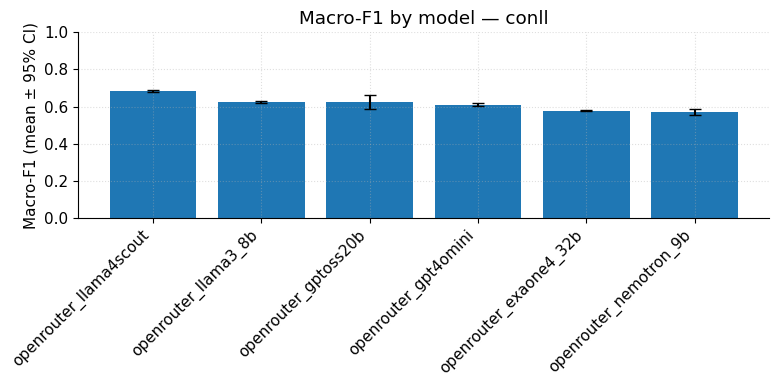

Saved: /root/2025_HCLT/runs/chart_macroF1_conll.png


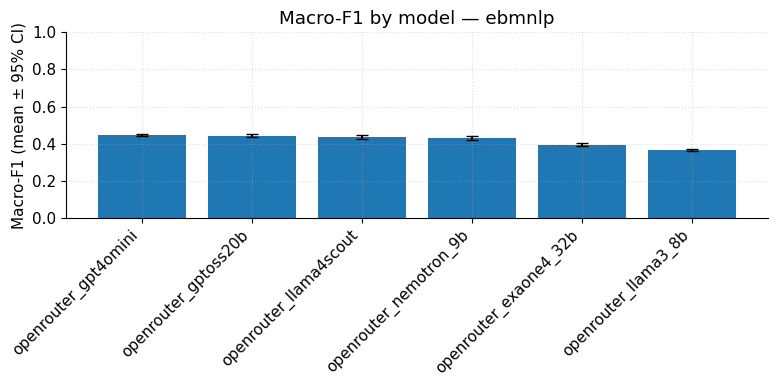

Saved: /root/2025_HCLT/runs/chart_macroF1_ebmnlp.png


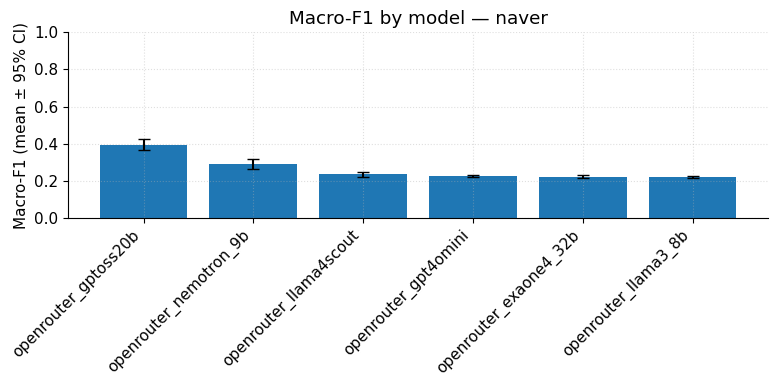

Saved: /root/2025_HCLT/runs/chart_macroF1_naver.png


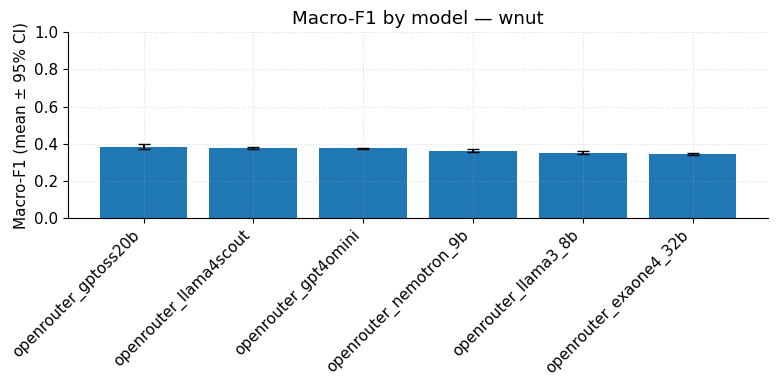

Saved: /root/2025_HCLT/runs/chart_macroF1_wnut.png


In [47]:
# %% [markdown]
# ## 차트 1) 데이터셋별 Macro-F1 (모델 막대, 평균 ± 95% CI)

# 앞 셀에서 만든 mean_std가 없으면 CSV에서 로드
if "mean_std" not in globals():
    mean_std = pd.read_csv("/root/2025_HCLT/runs/ner_reflection_agg_mean_std.csv")

# 보기 좋게 범위를 고정
YLIM = (0.0, 1.0)

for dset in sorted(mean_std["dataset"].dropna().unique()):
    sub = mean_std[mean_std["dataset"] == dset].copy()
    if len(sub) == 0:
        continue

    # 모델 정렬: macro_f1_mean 기준 내림차순
    sub = sub.sort_values("macro_f1_mean", ascending=False).reset_index(drop=True)

    # x축 위치
    x = np.arange(len(sub))

    # 대칭 에러바: 95% CI ≈ 1.96 * SE
    y = sub["macro_f1_mean"].values
    yerr = (sub["macro_f1_se"].fillna(0.0).values * 1.96)

    plt.figure(figsize=(8, 4))
    plt.bar(x, y, yerr=yerr, capsize=4)
    plt.xticks(x, sub["model"], rotation=45, ha="right")
    plt.ylim(*YLIM)
    plt.ylabel("Macro-F1 (mean ± 95% CI)")
    plt.title(f"Macro-F1 by model — {dset}")
    plt.tight_layout()

    out_png = f"/root/2025_HCLT/runs/chart_macroF1_{dset}.png"
    plt.savefig(out_png, dpi=150)
    plt.show()
    print(f"Saved: {out_png}")

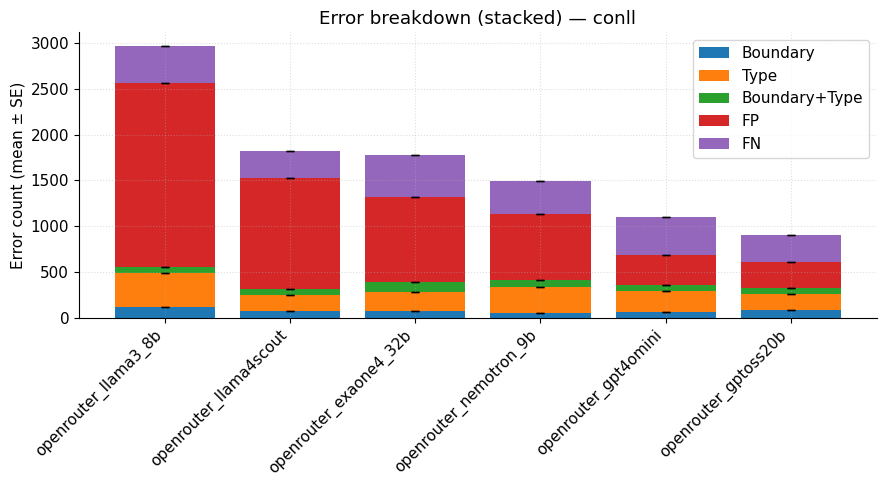

Saved: /root/2025_HCLT/runs/chart_errors_stack_conll.png


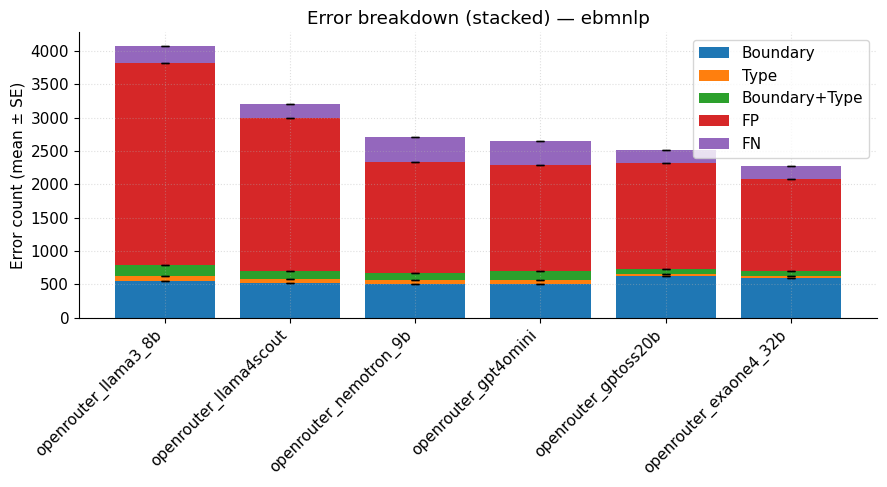

Saved: /root/2025_HCLT/runs/chart_errors_stack_ebmnlp.png


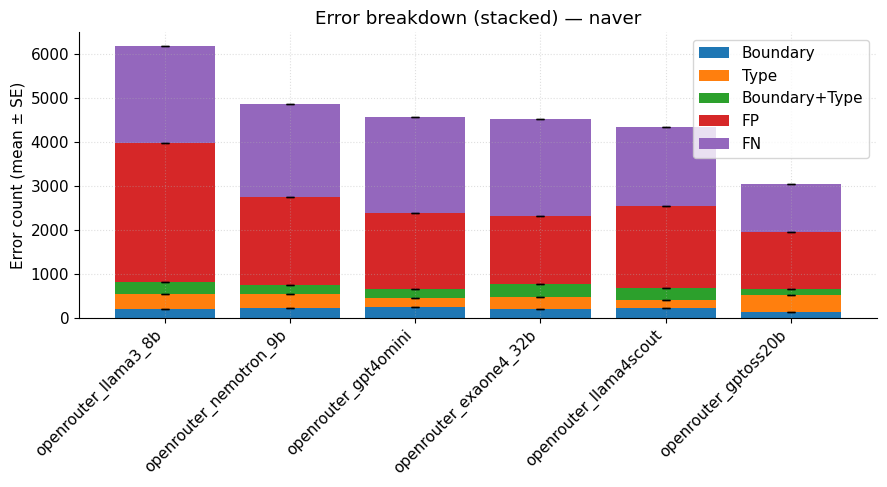

Saved: /root/2025_HCLT/runs/chart_errors_stack_naver.png


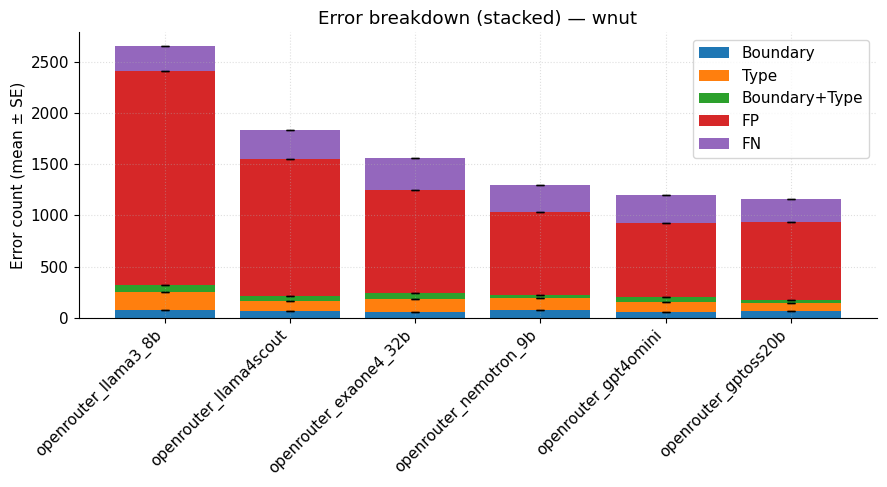

Saved: /root/2025_HCLT/runs/chart_errors_stack_wnut.png


In [48]:
# %% [markdown]
# ## 차트 2) 오류 유형 스택 막대 (데이터셋별, 평균 ± SE) — 컬럼 결손 견고화

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

csv_path = "/root/2025_HCLT/runs/ner_reflection_errors_byround.csv"

try:
    df_errors_hist = pd.read_csv(csv_path)
except FileNotFoundError:
    df_errors_hist = None
    print(f"⚠️ not found: {csv_path}")

if df_errors_hist is not None and len(df_errors_hist) > 0:
    # 필요한 컬럼 확보
    required_base = ["model","dataset","split"]
    for col in required_base:
        if col not in df_errors_hist.columns:
            df_errors_hist[col] = None

    # 없으면 기본값 보정
    if "round_idx" not in df_errors_hist.columns:
        df_errors_hist["round_idx"] = 0
    if "run_tag" not in df_errors_hist.columns:
        # 여러 실행이 한 파일에 섞여있지 않다면 단일 태그로 가정
        df_errors_hist["run_tag"] = "single"

    # 오류 컬럼 보정
    err_cols = ["boundary_error","type_error","boundary_type_error","fp","fn"]
    for c in err_cols:
        if c not in df_errors_hist.columns:
            df_errors_hist[c] = 0
        df_errors_hist[c] = pd.to_numeric(df_errors_hist[c], errors="coerce").fillna(0)

    # 마지막 라운드만 추출(최종 상태)
    df_last = (
        df_errors_hist.sort_values("round_idx")
        .groupby(["model","dataset","split","run_tag"], dropna=False)
        .tail(1)
        .reset_index(drop=True)
    )

    # 여러 실행(run_tag) 평균과 표준오차(SE) 집계
    def _mean_se_block(g, cols):
        out = {}
        n = g["run_tag"].nunique() if "run_tag" in g.columns else len(g)
        n = max(int(n), 1)
        for c in cols:
            vals = g[c].astype(float).to_numpy()
            out[f"{c}_mean"] = float(np.mean(vals)) if len(vals) else 0.0
            out[f"{c}_se"] = float(np.std(vals, ddof=1)/np.sqrt(n)) if n > 1 and len(vals) > 1 else 0.0
        return pd.Series(out)

    err_mean = (
        df_last.groupby(["model","dataset","split"], dropna=False)
        .apply(lambda g: _mean_se_block(g, err_cols))
        .reset_index()
    )

    # 데이터셋별 플롯
    for dset in sorted(err_mean["dataset"].dropna().unique()):
        sub = err_mean[err_mean["dataset"] == dset].copy()
        if len(sub) == 0:
            continue

        # 총 오류 평균으로 정렬
        sub["total_err_mean"] = (
            sub["boundary_error_mean"]
            + sub["type_error_mean"]
            + sub["boundary_type_error_mean"]
            + sub["fp_mean"]
            + sub["fn_mean"]
        )
        sub = sub.sort_values("total_err_mean", ascending=False).reset_index(drop=True)

        X = np.arange(len(sub))
        plt.figure(figsize=(9,5))

        bottoms = np.zeros(len(sub))
        legend_labels = {
            "boundary_error": "Boundary",
            "type_error": "Type",
            "boundary_type_error": "Boundary+Type",
            "fp": "FP",
            "fn": "FN",
        }
        palette = plt.cm.tab10.colors

        for i, col in enumerate(err_cols):
            means = sub[f"{col}_mean"].values
            ses   = sub[f"{col}_se"].values
            plt.bar(
                X, means, bottom=bottoms, yerr=ses, capsize=3,
                label=legend_labels[col], color=palette[i % len(palette)]
            )
            bottoms += means

        plt.xticks(X, sub["model"], rotation=45, ha="right")
        plt.ylabel("Error count (mean ± SE)")
        plt.title(f"Error breakdown (stacked) — {dset}")
        plt.legend()
        plt.tight_layout()
        out_png = f"/root/2025_HCLT/runs/chart_errors_stack_{dset}.png"
        plt.savefig(out_png, dpi=150)
        plt.show()
        print(f"Saved: {out_png}")
else:
    print("⚠️ df_errors_hist is empty or missing — 스택 에러 차트 생략")

In [49]:
# %% [markdown]
# ## 가용 리스트 만들기 (데이터셋/모델/ID) — 인덱스로 선택

# 결측 대비
for col in ["dataset","model","id"]:
    if col not in df_samples.columns:
        df_samples[col] = None

# 1) 데이터셋 리스트
DATASETS = sorted([d for d in df_samples["dataset"].dropna().unique().tolist()])

# 2) 데이터셋별 모델 리스트
MODELS_BY_DSET = {
    d: sorted(df_samples.loc[df_samples["dataset"] == d, "model"].dropna().unique().tolist())
    for d in DATASETS
}

# 3) (선택) 데이터셋+모델별 ID 리스트
def get_ids_for(dset: str, model: str|None=None):
    q = (df_samples["dataset"] == dset)
    if model is not None:
        q &= (df_samples["model"] == model)
    ids = df_samples.loc[q, "id"].dropna().astype(str).unique().tolist()
    # 정렬을 원하면 다음 줄 주석 해제
    # ids = sorted(ids)
    return ids

print("DATASETS:")
for i, d in enumerate(DATASETS):
    print(f"  [{i}] {d}")

# 보기 편한 요약
print("\nMODELS_BY_DSET:")
for d in DATASETS:
    print(f"  - {d}: {MODELS_BY_DSET[d]}")

DATASETS:
  [0] conll
  [1] ebmnlp
  [2] naver
  [3] wnut

MODELS_BY_DSET:
  - conll: ['openrouter_exaone4_32b', 'openrouter_gpt4omini', 'openrouter_gptoss20b', 'openrouter_llama3_8b', 'openrouter_llama4scout', 'openrouter_nemotron_9b']
  - ebmnlp: ['openrouter_exaone4_32b', 'openrouter_gpt4omini', 'openrouter_gptoss20b', 'openrouter_llama3_8b', 'openrouter_llama4scout', 'openrouter_nemotron_9b']
  - naver: ['openrouter_exaone4_32b', 'openrouter_gpt4omini', 'openrouter_gptoss20b', 'openrouter_llama3_8b', 'openrouter_llama4scout', 'openrouter_nemotron_9b']
  - wnut: ['openrouter_exaone4_32b', 'openrouter_gpt4omini', 'openrouter_gptoss20b', 'openrouter_llama3_8b', 'openrouter_llama4scout', 'openrouter_nemotron_9b']


In [50]:
# %% [markdown]
# ## 인덱스로 선택해서 미니뷰 생성

# 인덱스 선택 (원하면 바꿔서 실행)
DSET_IDX  = 2                      # DATASETS[DSET_IDX]
MODEL_IDX = 0                      # MODELS_BY_DSET[DATASETS[DSET_IDX]][MODEL_IDX]
USE_MODEL = True                   # 모델까지 고를지 여부
ID_IDX    = 0                   # 특정 샘플 하나를 고를 거면 인덱스 지정, 아니면 None

# 1) 데이터셋 선택
TARGET_DSET = DATASETS[DSET_IDX] if len(DATASETS) else None

# 2) 모델 선택 (선택)
TARGET_MODEL = None
if USE_MODEL and TARGET_DSET is not None:
    models = MODELS_BY_DSET.get(TARGET_DSET, [])
    if models:
        TARGET_MODEL = models[MODEL_IDX % len(models)]

# 3) ID 리스트 만들고 선택(선택)
ID_LIST = get_ids_for(TARGET_DSET, TARGET_MODEL) if TARGET_DSET else []
TARGET_ID = None if ID_IDX is None or not ID_LIST else ID_LIST[ID_IDX % len(ID_LIST)]

print(f"TARGET_DSET   = {TARGET_DSET}")
print(f"TARGET_MODEL  = {TARGET_MODEL}")
print(f"Available IDs = {len(ID_LIST)} (showing first 10): {ID_LIST[:10]}")
print(f"TARGET_ID     = {TARGET_ID}")

# 4) 필터 적용
q = (df_samples["dataset"] == TARGET_DSET)
if TARGET_MODEL is not None:
    q &= (df_samples["model"] == TARGET_MODEL)
if TARGET_ID is not None:
    q &= (df_samples["id"].astype(str) == str(TARGET_ID))

tmp = df_samples.loc[q].copy()

# 미니뷰
cols_show = [c for c in ["model","dataset","split","id","f1","text"] if c in tmp.columns]
display(tmp[cols_show].head(20))

TARGET_DSET   = naver
TARGET_MODEL  = openrouter_exaone4_32b
Available IDs = 1000 (showing first 10): ['dd3c2824-01ef-4395-817b-4508ca31ba58', '4d184a7d-e0b6-4f81-9dc8-7443a6934a64', 'df6ceeca-1f70-4bf1-b42c-85d7a24d6db2', 'b5f12457-a9d8-45b6-96e2-c3e4a02bfb5d', 'f90213e7-8a65-455f-b35f-cbc2e547d487', '92ada370-456e-4472-9443-0398677ac32f', '970e5d50-c6f7-4dd9-8e4b-81bfa39afc7a', 'f4452846-5a5a-4cb5-9794-82c8e9ba7032', 'c38d0e7f-329d-4b78-9d4c-43e45b3fd6d8', 'f8863c7c-f03e-4f53-99b0-b88bb542af60']
TARGET_ID     = dd3c2824-01ef-4395-817b-4508ca31ba58


,model,dataset,split,id,f1,text
1200,openrouter_exaone4_32b,naver,test,dd3c2824-01ef-4395-817b-4508ca31ba58,0.0,4.271로 떨어졌다 .


In [51]:
# %% [markdown]
# ## iteration 단위 성능/오류 집계 (역사(history) → df_iters)
# - critic 단계는 pred가 없을 수 있으니 건너뜀
# - run_tag가 있으면 함께 보존(여러 번 반복 실행 결과의 평균/에러밴드에 필요)

iter_rows = []

# 안전 대비: 필요한 컬럼이 없으면 만들어두기
for col in ["gold", "history", "model", "dataset", "split", "id", "run_tag"]:
    if col not in df_samples.columns:
        df_samples[col] = None

for _, row in df_samples.iterrows():
    gold = row.get("gold") or []
    history = row.get("history")
    if not isinstance(history, list):  # history가 없거나 비정상일 때 스킵
        continue
        
    model = row.get("model")
    dataset = row.get("dataset")
    split = row.get("split")
    sample_id = row.get("id")
    run_tag = row.get("run_tag")  # 여러 실행을 구분하는 태그(있으면 평균 낼 때 유용)

    # 히스토리 내에서 pred가 있는 단계만 순서대로 사용
    iter_idx = 0
    for h in history:
        if not isinstance(h, dict):
            continue
        if "pred" not in h:
            continue  # critic 단계 등 pred 없는 스텝은 건너뜀

        pred = h.get("pred") or []
        stats = classify_errors(gold, pred)
        p, r, f = prf1_from_counts(stats["tp_exact"], stats["fp"], stats["fn"])

        iter_rows.append({
            "model": model,
            "dataset": dataset,
            "split": split,
            "id": sample_id,
            "run_tag": run_tag,      # 여러 번 실행 평균/에러밴드용
            "iter": iter_idx,        # 0,1,2,... (extract=0, 첫 revise=1 ...)
            "precision": p,
            "recall": r,
            "f1": f,
            **stats
        })
        iter_idx += 1

df_iters = pd.DataFrame(iter_rows)

print("df_iters shape:", df_iters.shape)
display(df_iters.head(10))

df_iters shape: (497519, 15)


,model,dataset,split,id,run_tag,iter,precision,recall,f1,tp_exact,boundary_error,type_error,boundary_type_error,fp,fn
0,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,0,1.0,0.5,0.666667,1,0,0,0,0,1
1,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,1,0.0,0.0,0.000000,0,0,0,0,0,2
2,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,2,1.0,1.0,1.000000,2,0,0,0,0,0
3,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,3,0.0,0.0,0.000000,0,0,0,0,0,2
4,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,4,1.0,0.5,0.666667,1,0,0,0,0,1
5,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,5,0.0,0.0,0.000000,0,0,0,0,0,2
6,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,6,1.0,1.0,1.000000,2,0,0,0,0,0
7,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,7,0.0,0.0,0.000000,0,0,0,0,0,2
8,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,8,0.5,0.5,0.500000,1,0,0,0,1,1
9,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,9,0.0,0.0,0.000000,0,0,0,0,0,2


In [52]:
# %% [markdown]
# ## 짝수 iteration만 사용 (extract=0, revise=2,4,...) + round 인덱스 생성

assert "df_iters" in globals() and len(df_iters) > 0, "df_iters를 먼저 생성하세요."

# 짝수 iteration만 사용
df_iters_even = df_iters[df_iters["iter"] % 2 == 0].copy()

# 사람이 읽기 쉬운 round 번호 (0,1,2,...) 부여
df_iters_even["round"] = (df_iters_even["iter"] // 2).astype(int)

# 필요 컬럼만 유지(안전)
keep_cols = ["model","dataset","split","id","run_tag","round","precision","recall","f1",
             "tp_exact","boundary_error","type_error","boundary_type_error","fp","fn"]
for c in keep_cols:
    if c not in df_iters_even.columns:
        # 없는 건 생성해둠(예: run_tag 없을 수 있음)
        df_iters_even[c] = np.nan

df_iters_even = df_iters_even[keep_cols].reset_index(drop=True)
df_iters_even.head()

,model,dataset,split,id,run_tag,round,precision,recall,f1,tp_exact,boundary_error,type_error,boundary_type_error,fp,fn
0,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,0,1.0,0.5,0.666667,1,0,0,0,0,1
1,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,1,1.0,1.0,1.000000,2,0,0,0,0,0
2,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,2,1.0,0.5,0.666667,1,0,0,0,0,1
3,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,3,1.0,1.0,1.000000,2,0,0,0,0,0
4,openrouter_gpt4omini,conll,test,9ebf26c5-23ed-4874-889d-3c6d8f56a0bf,20250912_190149,4,0.5,0.5,0.500000,1,0,0,0,1,1


In [53]:
# %% [markdown]
# ## round 기준 평균/신뢰구간 집계 (df_curve_reduced)

def mean_ci_from_groups(df, group_cols, rep_col):
    """
    group_cols: ['model','dataset','round'] 같은 상위 그룹핑 키
    rep_col   : 반복(replica) 식별 열 (예: 'run_tag' 또는 'id')
    """
    per_rep = (
        df.groupby(group_cols + [rep_col], dropna=False)
          .agg(precision=('precision','mean'),
               recall=('recall','mean'),
               f1=('f1','mean'))
          .reset_index()
    )
    agg = (
        per_rep.groupby(group_cols, dropna=False)
               .agg(precision_mean=('precision','mean'),
                    recall_mean=('recall','mean'),
                    f1_mean=('f1','mean'),
                    f1_std=('f1','std'),
                    n_runs=('f1','count'))
               .reset_index()
    )
    agg['f1_ci95'] = 1.96 * (agg['f1_std'].fillna(0)) / np.sqrt(agg['n_runs'].clip(lower=1))
    return agg

group_keys = ['model','dataset','round']

if 'run_tag' in df_iters_even.columns and df_iters_even['run_tag'].notna().any():
    df_curve = mean_ci_from_groups(df_iters_even, group_keys, rep_col='run_tag')
elif 'id' in df_iters_even.columns:
    df_curve = mean_ci_from_groups(df_iters_even, group_keys, rep_col='id')
else:
    df_curve = (
        df_iters_even.groupby(group_keys, dropna=False)
                     .agg(precision_mean=('precision','mean'),
                          recall_mean=('recall','mean'),
                          f1_mean=('f1','mean'))
                     .reset_index()
    )
    df_curve['f1_std'] = 0.0
    df_curve['n_runs'] = 1
    df_curve['f1_ci95'] = 0.0

df_curve = df_curve.sort_values(group_keys).reset_index(drop=True)
df_curve.head()

,model,dataset,round,precision_mean,recall_mean,f1_mean,f1_std,n_runs,f1_ci95
0,openrouter_exaone4_32b,conll,0,0.526750,0.540167,0.516656,0.003328,5,0.002917
1,openrouter_exaone4_32b,conll,1,0.412989,0.448592,0.395614,0.006451,5,0.005655
2,openrouter_exaone4_32b,conll,2,0.446420,0.463912,0.434430,0.011264,5,0.009873
3,openrouter_exaone4_32b,conll,3,0.448587,0.492016,0.440741,0.005419,5,0.004750
4,openrouter_exaone4_32b,conll,4,0.451395,0.475390,0.439603,0.004372,5,0.003832


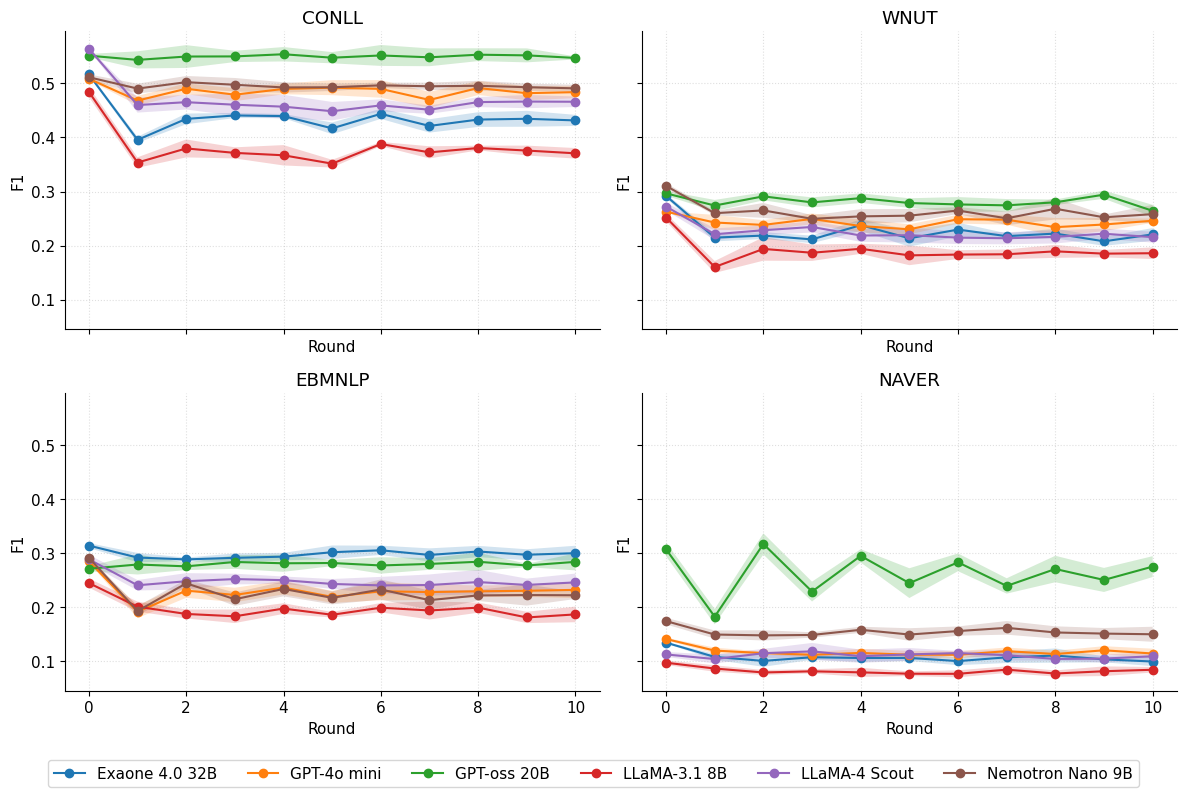

Saved: /root/2025_HCLT/runs/chart_round_f1_all.png
Saved: /root/2025_HCLT/runs/chart_round_f1_all.pdf


In [ ]:
# %% [markdown]
# ## round별 F1 곡선 + 에러밴드 (4개 데이터셋 한 번에)

datasets_all = ["conll", "wnut", "ebmnlp", "naver"]

MODEL_PRETTY = {
    "openrouter_gpt4omini": "GPT-4o mini",
    "openrouter_llama4scout": "LLaMA-4 Scout",
    "openrouter_exaone4_32b": "Exaone 4.0 32B",
    "openrouter_gptoss20b": "GPT-oss 20B",
    "openrouter_llama3_8b": "LLaMA-3.1 8B",
    "openrouter_qwen3_8b": "Qwen-3 8B",
    "openrouter_nemotron_9b": "Nemotron Nano 9B",
}

nrows, ncols = 2, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(12, 8), sharex=True, sharey=True)

for ax, dset in zip(axes.ravel(), datasets_all):
    sub = df_curve[df_curve["dataset"] == dset].copy()
    if len(sub) == 0:
        ax.set_visible(False)
        continue

    for m in sub["model"].dropna().unique():
        subm = sub[sub["model"] == m].sort_values("round")
        x = subm["round"].values
        y = subm["f1_mean"].values
        label = MODEL_PRETTY.get(m, m)  # 매핑된 이름 사용
        ax.plot(x, y, marker="o", label=label)

        if "f1_ci95" in subm.columns:
            ci = subm["f1_ci95"].values
            ax.fill_between(x, y - ci, y + ci, alpha=0.2)

    ax.set_title(dset.upper())
    ax.set_xlabel("Round")
    ax.set_ylabel("F1")
    ax.grid(True)

# 범례는 전체 공통으로
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=max(1, len(labels)))
fig.tight_layout(rect=[0, 0.05, 1, 1])

out_png = "/root/2025_HCLT/runs/chart_round_f1_all.png"
plt.savefig(out_png, dpi=150)

out_pdf = "/root/2025_HCLT/runs_ffinal/chart_round_f1_all.pdf"
plt.savefig(out_pdf)

plt.show()
print(f"Saved: {out_png}")
print(f"Saved: {out_pdf}")

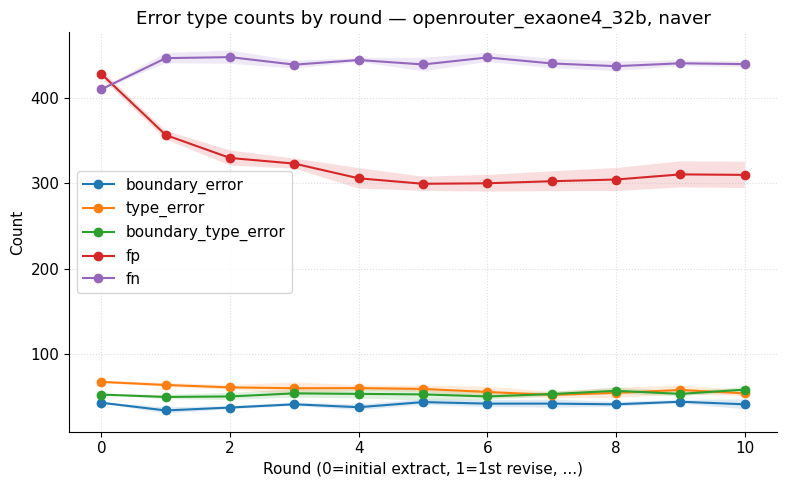

Saved: /root/2025_HCLT/runs/chart_error_openrouter_exaone4_32b_naver.png


In [ ]:
# %% [markdown]
# ## round(=짝수 iteration) 기준 오류 유형 변화 (라인 차트)
# - df_iters_even 이 있으면 사용, 없으면 df_iters에서 짝수만 필터
# - 여러 번 실행(run_tag)이 있으면 run별 합을 내고 평균 + 95% CI 에러밴드 표시
# - 단일 실행만 있으면 에러밴드는 표시 안 함

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 준비: 짝수 iteration만 사용해 round 생성 ---
if 'df_iters_even' in globals() and len(df_iters_even) > 0:
    df_src = df_iters_even.copy()
else:
    assert 'df_iters' in globals() and len(df_iters) > 0, "먼저 df_iters를 생성하세요."
    df_src = df_iters[df_iters["iter"] % 2 == 0].copy()
    df_src["round"] = (df_src["iter"] // 2).astype(int)

# --- 집계 ---
err_cols = ["boundary_error","type_error","boundary_type_error","fp","fn"]

# 여러 번 실행(run_tag)이 있다면 run 단위 합계 → 평균/CI
has_run_tag = ("run_tag" in df_src.columns) and df_src["run_tag"].notna().any()

if has_run_tag:
    # 각 run_tag별로 round 합계
    per_run = (
        df_src.groupby(["model","dataset","round","run_tag"], dropna=False)[err_cols]
              .sum()
              .reset_index()
    )
    # round별 평균/표준편차/횟수 → 95% CI
    df_err_curve = (
        per_run.groupby(["model","dataset","round"], dropna=False)
               .agg(**{f"{c}_mean": (c, "mean") for c in err_cols},
                    **{f"{c}_std":  (c, "std")  for c in err_cols},
                    n_runs=("run_tag","count"))
               .reset_index()
    )
    for c in err_cols:
        df_err_curve[f"{c}_ci95"] = 1.96 * (df_err_curve[f"{c}_std"].fillna(0)) / np.sqrt(df_err_curve["n_runs"].clip(lower=1))
else:
    # 단일 실행이면 그냥 round 합계
    df_err_curve = (
        df_src.groupby(["model","dataset","round"], dropna=False)[err_cols]
              .sum()
              .reset_index()
    )
    for c in err_cols:
        df_err_curve[f"{c}_mean"] = df_err_curve[c].astype(float)
        df_err_curve[f"{c}_ci95"] = 0.0

# --- 플롯: 특정 모델/데이터셋 ---
target_model = "openrouter_exaone4_32b"
target_dataset = "naver"

sub = df_err_curve[(df_err_curve["model"] == target_model) &
                   (df_err_curve["dataset"] == target_dataset)].sort_values("round")

plt.figure(figsize=(8,5))
for c in err_cols:
    y = sub[f"{c}_mean"].values
    x = sub["round"].values
    plt.plot(x, y, marker="o", label=c)
    # 에러밴드(여러 run 있을 때만 유효)
    if has_run_tag:
        ci = sub[f"{c}_ci95"].values
        plt.fill_between(x, y - ci, y + ci, alpha=0.15)

plt.title(f"Error type counts by round — {target_model}, {target_dataset}")
plt.xlabel("Round (0=initial extract, 1=1st revise, ...)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
out_png = f"/root/2025_HCLT/runs_ffinal/chart_error_{target_model}_{target_dataset}.png"
plt.tight_layout()
plt.savefig(out_png, dpi=150)
plt.show()
print(f"Saved: {out_png}")

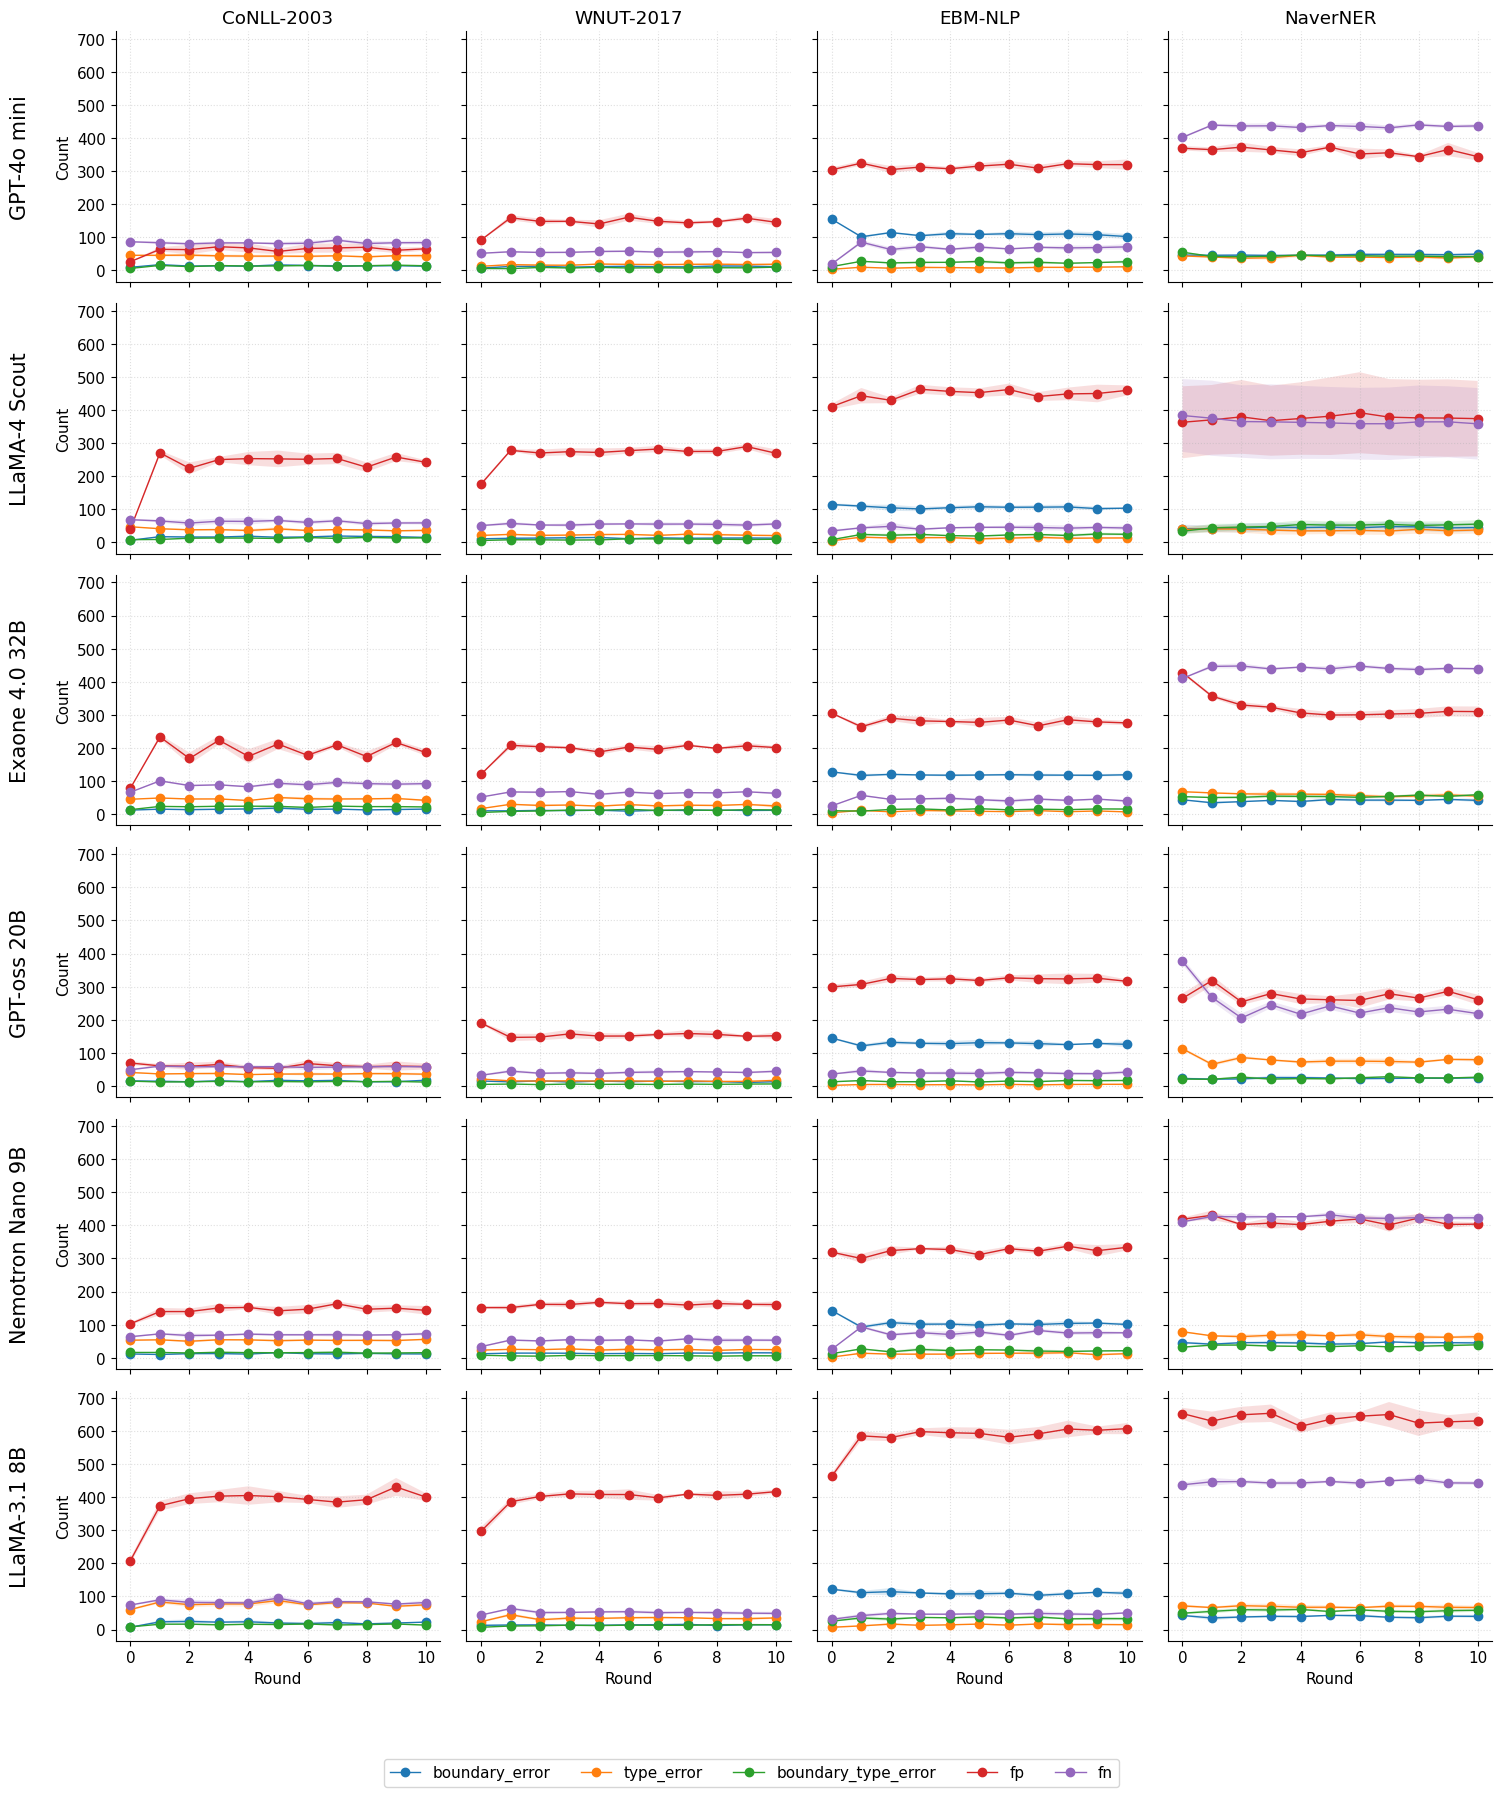

Saved: /root/2025_HCLT/runs/chart_error_all_grid.png
Saved: /root/2025_HCLT/runs/chart_error_all_grid.pdf


In [ ]:
# %% [markdown]
# ## 모든 모델×데이터셋 오류 유형 변화 — 한 눈에 보기 (subplots grid)

# 원하는 순서로 직접 지정
datasets_all = ["conll", "wnut", "ebmnlp", "naver"]
models_all = [
    "openrouter_gpt4omini",      # gpt-4o mini
    "openrouter_llama4scout",    # llama 4
    "openrouter_exaone4_32b",    # exaone
    "openrouter_gptoss20b",      # gpt oss
    "openrouter_nemotron_9b",    # nemotron
    "openrouter_llama3_8b",      # llama3 8b
]

# === 모델/데이터셋 표준 이름 매핑(플롯 라벨 깔끔하게) ===
MODEL_PRETTY = {
    "openrouter_gpt4omini": "GPT-4o mini",
    "openrouter_llama4scout": "LLaMA-4 Scout",
    "openrouter_exaone4_32b": "Exaone 4.0 32B",
    "openrouter_gptoss20b": "GPT-oss 20B",
    "openrouter_llama3_8b": "LLaMA-3.1 8B",
    "openrouter_qwen3_8b": "Qwen-3 8B",
    "openrouter_nemotron_9b": "Nemotron Nano 9B",
}

DATASET_PRETTY = {
    "conll": "CoNLL-2003",
    "wnut": "WNUT-2017",
    "ebmnlp": "EBM-NLP",
    "naver": "NaverNER",
}

nrows, ncols = len(models_all), len(datasets_all)
fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows), sharex=True, sharey=True)

if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = np.array([axes])
elif ncols == 1:
    axes = np.array([[ax] for ax in axes])

for i, m in enumerate(models_all):
    for j, dset in enumerate(datasets_all):
        ax = axes[i, j]
        sub = df_err_curve[(df_err_curve["model"] == m) &
                           (df_err_curve["dataset"] == dset)].sort_values("round")
        if len(sub) == 0:
            ax.set_visible(False)
            continue

        for c in err_cols:
            y = sub[f"{c}_mean"].values
            x = sub["round"].values
            ax.plot(x, y, marker="o", label=c, linewidth=1)
            if has_run_tag:
                ci = sub[f"{c}_ci95"].values
                ax.fill_between(x, y - ci, y + ci, alpha=0.15)

        ax.grid(True)

        # --- 열 첫 번째 행에만 데이터셋 이름 표시 ---
        if i == 0:
            ax.set_title(DATASET_PRETTY.get(dset, dset))

        # --- 마지막 행에만 X축 레이블 추가 ---
        if i == nrows - 1:
            ax.set_xlabel("Round")

        # --- 행 첫 번째 열에만 모델 이름 표시 ---
        if j == 0:
            ax.set_ylabel("Count")
            ax.annotate(
                MODEL_PRETTY.get(m, m),
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - 15, 0),
                xycoords=ax.yaxis.label,
                textcoords="offset points",
                ha="right", va="center", fontsize=15, rotation=90
            )

# 전체 공통 y축 라벨
# fig.text(0.04, 0.5, "Count", va="center", rotation="vertical", fontsize=12)

# 범례는 아래쪽에 전체 공통으로
handles, labels = axes[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=len(err_cols))

fig.tight_layout(rect=[0.05, 0.05, 1, 1])

out_png = "/root/2025_HCLT/runs_ffinal/chart_error_all_grid.png"
plt.savefig(out_png, dpi=150)

out_pdf = "/root/2025_HCLT/runs_ffinal/chart_error_all_grid.pdf"
plt.savefig(out_pdf)

plt.show()
print(f"Saved: {out_png}")
print(f"Saved: {out_pdf}")

In [57]:
# df_samples → df_iters 재구축
def _norm_text(s: str) -> str:
    import re
    s = (s or "").strip().strip('"\''"“”‘’")
    s = re.sub(r"\s+", " ", s)
    return s.lower()

def prf1_from_counts(tp, fp, fn):
    p = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    r = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f = 2*p*r/(p+r) if (p+r) > 0 else 0.0
    return p, r, f

def char_overlap(a: str, b: str) -> int:
    if not a or not b:
        return 0
    if a in b or b in a:
        return min(len(a), len(b))
    return 0

def classify_errors(gold, pred):
    gold = gold or []
    pred = pred or []
    G = [(_norm_text(g.get("text","")), str(g.get("type","")).strip()) for g in gold]
    P = [(_norm_text(p.get("text","")), str(p.get("type","")).strip()) for p in pred]
    G_set, P_set = set(G), set(P)
    tp_exact = len(G_set & P_set)
    G_rem = [g for g in G if g not in P_set]
    P_rem = [p for p in P if p not in G_set]

    type_only = 0
    text2gold_types = {}
    for t, ty in G_rem:
        text2gold_types.setdefault(t, set()).add(ty)
    matched_P, matched_G = set(), set()
    for i, (t_p, ty_p) in enumerate(P_rem):
        if t_p in text2gold_types and ty_p not in text2gold_types[t_p]:
            type_only += 1
            matched_P.add(i)

    boundary_only = 0
    boundary_type_both = 0
    for i, (t_p, ty_p) in enumerate(P_rem):
        if i in matched_P: 
            continue
        best = (-1, -1)
        for j, (t_g, ty_g) in enumerate(G_rem):
            if j in matched_G:
                continue
            ov = char_overlap(t_p, t_g)
            if ov > best[0]:
                best = (ov, j)
        if best[0] > 0:
            j = best[1]
            t_g, ty_g = G_rem[j]
            if ty_p == ty_g:
                if t_p != t_g:
                    boundary_only += 1
                matched_P.add(i); matched_G.add(j)
            else:
                boundary_type_both += 1
                matched_P.add(i); matched_G.add(j)

    fp = 0
    for i in range(len(P_rem)):
        if i not in matched_P and P_rem[i][0] not in text2gold_types:
            fp += 1
    fn = 0
    for j in range(len(G_rem)):
        if j not in matched_G:
            fn += 1

    return dict(
        tp_exact=tp_exact,
        boundary_error=boundary_only,
        type_error=type_only,
        boundary_type_error=boundary_type_both,
        fp=fp,
        fn=fn,
    )

# 1) df_iters 만들기 (history에서 pred가 있는 step만)
iter_rows = []
for _, row in df_samples.iterrows():
    gold = row.get("gold", [])
    history = row.get("history", [])
    model = row.get("model")
    dataset = row.get("dataset")
    split = row.get("split")
    sample_id = row.get("id")
    run_tag = row.get("run_tag") if "run_tag" in row else None

    for idx, h in enumerate(history or []):
        if "pred" not in h:
            continue
        pred = h.get("pred", [])
        stats = classify_errors(gold, pred)
        p, r, f = prf1_from_counts(stats["tp_exact"], stats["fp"], stats["fn"])
        iter_rows.append({
            "model": model,
            "dataset": dataset,
            "split": split,
            "id": sample_id,
            "run_tag": run_tag,
            "iter": idx,
            "precision": p,
            "recall": r,
            "f1": f,
            **stats
        })

df_iters = pd.DataFrame(iter_rows)
print("df_iters:", df_iters.shape)

# 2) (짝수 iter = revise 단계만) 선택한 곡선을 바로 쓰고 싶으면 여기서 필터링
df_iters_even = df_iters[df_iters["iter"] % 2 == 0].copy()

# 3) 모델×데이터셋×iteration 단위로 평균 PRF1 (전체 / 짝수전용)
df_curve = df_iters.groupby(["model","dataset","iter"]).agg(
    precision=("precision","mean"),
    recall=("recall","mean"),
    f1=("f1","mean")
).reset_index()

df_curve_even = df_iters_even.groupby(["model","dataset","iter"]).agg(
    precision=("precision","mean"),
    recall=("recall","mean"),
    f1=("f1","mean")
).reset_index()

print("df_curve:", df_curve.shape, "| df_curve_even:", df_curve_even.shape)

df_iters: (497519, 15)
df_curve: (504, 6) | df_curve_even: (264, 6)


In [58]:
# %% [markdown]
# ## 각 모델×데이터셋별 마지막 round 성능 (여러 run 평균)

# df_curve_even이 있으면 사용 (짝수 iteration만 = revise 단계)
if "df_curve_even" in globals() and len(df_curve_even) > 0:
    src = df_curve_even.copy()
else:
    src = df_curve.copy()

# run_tag가 있으면 run별 마지막 round → 평균
has_run_tag = ("run_tag" in src.columns) and src["run_tag"].notna().any()

if has_run_tag:
    # run별 마지막 라운드만 선택
    df_last = (
        src.sort_values("iter")
           .groupby(["model","dataset","run_tag"], dropna=False)
           .tail(1)
    )
    # 모델×데이터셋별 평균
    df_last = (
        df_last.groupby(["model","dataset"], dropna=False)[["precision","recall","f1"]]
               .mean()
               .reset_index()
    )
else:
    # 단일 실행인 경우
    df_last = src.sort_values("iter").groupby(["model","dataset"], dropna=False).tail(1)

df_last = df_last.sort_values("f1", ascending=False).reset_index(drop=True)
display(df_last)

,model,dataset,iter,precision,recall,f1
0,openrouter_gptoss20b,conll,20,0.564913,0.555985,0.549015
1,openrouter_nemotron_9b,conll,20,0.499216,0.526421,0.492461
2,openrouter_gpt4omini,conll,20,0.503227,0.494324,0.484213
3,openrouter_llama4scout,conll,20,0.438867,0.563317,0.466607
4,openrouter_exaone4_32b,conll,20,0.446313,0.470114,0.432746
5,openrouter_llama3_8b,conll,20,0.346734,0.488063,0.371407
6,openrouter_exaone4_32b,ebmnlp,20,0.266230,0.383000,0.296957
7,openrouter_gptoss20b,naver,20,0.309867,0.326666,0.292153
8,openrouter_gptoss20b,ebmnlp,20,0.242542,0.373681,0.276314
9,openrouter_gptoss20b,wnut,20,0.250871,0.304271,0.262587


In [59]:
# %% [markdown]
# ## 케이스 스터디: Gold vs Pred 정렬 유틸

import re
from typing import List, Dict, Any
from IPython.display import display, HTML

def _norm_text(s: str) -> str:
    s = (s or "").strip().strip('"\''"“”‘’")
    s = re.sub(r"\s+", " ", s)
    return s.lower()

def _overlap(a: str, b: str) -> bool:
    if not a or not b:
        return False
    a, b = _norm_text(a), _norm_text(b)
    return (a in b) or (b in a)

def align_gold_pred(gold: List[Dict[str,Any]], pred: List[Dict[str,Any]]) -> List[Dict[str,Any]]:
    """
    Gold vs Pred 라벨 정렬 (Case Study용):
      status ∈ {TP, BOUNDARY, TYPE, BOUNDARY+TYPE, FP, FN}
    우선순위:
      1. Exact (text+type 일치)
      2. Type (텍스트 동일, 타입 다름)
      3. Boundary (부분겹침, 타입 동일)
      4. Boundary+Type (부분겹침, 타입 다름)
      5. 남은 Pred → FP
      6. 남은 Gold → FN
    """
    gold = gold or []
    pred = pred or []
    G = [{"text": g.get("text",""), "type": str(g.get("type","")).strip(), "used": False} for g in gold]
    P = [{"text": p.get("text",""), "type": str(p.get("type","")).strip(), "used": False} for p in pred]

    rows = []

    # 1) Exact
    for g in G:
        for p in P:
            if not g["used"] and not p["used"]:
                if _norm_text(g["text"]) == _norm_text(p["text"]) and g["type"] == p["type"]:
                    rows.append({"gold_text": g["text"], "gold_type": g["type"],
                                 "pred_text": p["text"], "pred_type": p["type"], "status": "TP"})
                    g["used"] = p["used"] = True

    # 2) Type-only
    for g in G:
        for p in P:
            if not g["used"] and not p["used"]:
                if _norm_text(g["text"]) == _norm_text(p["text"]) and g["type"] != p["type"]:
                    rows.append({"gold_text": g["text"], "gold_type": g["type"],
                                 "pred_text": p["text"], "pred_type": p["type"], "status": "TYPE"})
                    g["used"] = p["used"] = True

    # 3) Boundary-only
    for g in G:
        for p in P:
            if not g["used"] and not p["used"]:
                if g["type"] == p["type"] and _overlap(g["text"], p["text"]) and _norm_text(g["text"]) != _norm_text(p["text"]):
                    rows.append({"gold_text": g["text"], "gold_type": g["type"],
                                 "pred_text": p["text"], "pred_type": p["type"], "status": "BOUNDARY"})
                    g["used"] = p["used"] = True

    # 4) Boundary+Type
    for g in G:
        for p in P:
            if not g["used"] and not p["used"]:
                if _overlap(g["text"], p["text"]) and g["type"] != p["type"]:
                    rows.append({"gold_text": g["text"], "gold_type": g["type"],
                                 "pred_text": p["text"], "pred_type": p["type"], "status": "BOUNDARY+TYPE"})
                    g["used"] = p["used"] = True

    # 5) FP
    for p in P:
        if not p["used"]:
            rows.append({"gold_text": "", "gold_type": "",
                         "pred_text": p["text"], "pred_type": p["type"], "status": "FP"})
            p["used"] = True

    # 6) FN
    for g in G:
        if not g["used"]:
            rows.append({"gold_text": g["text"], "gold_type": g["type"],
                         "pred_text": "", "pred_type": "", "status": "FN"})
            g["used"] = True

    return rows

# 색상 팔레트 (status별)
STATUS_COLORS = {
    "TP": "#c6f6d5",               # green-100
    "BOUNDARY": "#fefcbf",         # yellow-100
    "TYPE": "#bee3f8",             # blue-100
    "BOUNDARY+TYPE": "#fbd38d",    # orange-200
    "FP": "#fed7d7",               # red-200
    "FN": "#e9d8fd",               # purple-200
}

In [60]:
# %% [markdown]
# ## 사용 가능한 모델/데이터셋 목록 확인

available_models   = sorted(df_samples["model"].dropna().unique())
available_datasets = sorted(df_samples["dataset"].dropna().unique())

print("Available models:", available_models)
print("Available datasets:", available_datasets)

Available models: ['openrouter_exaone4_32b', 'openrouter_gpt4omini', 'openrouter_gptoss20b', 'openrouter_llama3_8b', 'openrouter_llama4scout', 'openrouter_nemotron_9b']
Available datasets: ['conll', 'ebmnlp', 'naver', 'wnut']


In [61]:
# =========================
# 케이스 스터디 대시보드 (compact, 한눈에 보기)
# =========================
from IPython.display import display, HTML
import html

def _chip(txt, bg="#e2e8f0"):
    return f"<span style='display:inline-block;padding:2px 8px;margin:2px;border-radius:999px;background:{bg};font-size:12px'>{html.escape(str(txt))}</span>"

def _chips_for_spans(spans, palette="#cbd5e1"):
    if not spans:
        return "<em style='color:#94a3b8'>None</em>"
    return " ".join(_chip(f"{s.get('text','')} → {s.get('type','')}", palette) for s in spans)

def _panel_title(i, stage, p=None, r=None, f=None):
    tail = ""
    if p is not None:
        tail = f" | P={p:.3f} R={r:.3f} F1={f:.3f}"
    return f"Iter {i} — {stage}{tail}"

def prf1_from_aligned(aligned):
    tp = sum(1 for r in aligned if r["status"]=="TP")
    fp = sum(1 for r in aligned if r["status"]=="FP")
    fn = sum(1 for r in aligned if r["status"]=="FN")
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    rec  = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2*prec*rec/(prec+rec) if (prec+rec) > 0 else 0.0
    return prec, rec, f1

def _aligned_table_html(aligned):
    rows = []
    for r in aligned:
        color = STATUS_COLORS.get(r["status"], "#fff")
        rows.append(
            f"<tr style='background:{color}'>"
            f"<td>{html.escape(r['gold_text'])}</td><td>{html.escape(r['gold_type'])}</td>"
            f"<td>{html.escape(r['pred_text'])}</td><td>{html.escape(r['pred_type'])}</td>"
            f"<td><b>{html.escape(r['status'])}</b></td>"
            "</tr>"
        )
    return f"""
    <table border="1" cellspacing="0" cellpadding="6" style="border-collapse:collapse;width:100%">
      <thead>
        <tr style="background:#f1f5f9">
          <th>Gold text</th><th>Gold type</th>
          <th>Pred text</th><th>Pred type</th>
          <th>Status</th>
        </tr>
      </thead>
      <tbody>
        {''.join(rows)}
      </tbody>
    </table>
    """

def render_case_dashboard(row, even_only=True, max_iters=None):
    if row is None:
        display(HTML("<p><i>no sample selected</i></p>"))
        return
    model = row.get("model")
    dataset = row.get("dataset")
    sid = row.get("id")
    text = row.get("text","")
    gold = row.get("gold", [])
    pred_final = row.get("pred", [])
    hist = row.get("history", []) or []

    # 헤더 + 문장
    header = f"""
    <div style="font-family:Inter,system-ui,-apple-system,Segoe UI,Roboto,Arial; line-height:1.45">
      <div style="display:flex;justify-content:space-between;align-items:center;margin-bottom:8px">
        <div>
          <div style="font-size:18px;font-weight:700">Case Study</div>
          <div style="color:#475569;font-size:13px">Model: <b>{html.escape(str(model))}</b> &nbsp;|&nbsp; Dataset: <b>{html.escape(str(dataset))}</b> &nbsp;|&nbsp; ID: <b>{html.escape(str(sid))}</b></div>
        </div>
      </div>
      <div style="background:#f8fafc;border:1px solid #e2e8f0;border-radius:10px;padding:10px;margin-bottom:10px">
        <div style="font-size:12px;color:#475569;margin-bottom:6px">Text</div>
        <div style="white-space:pre-wrap">{html.escape(text)}</div>
      </div>
    """

    # 골드/최종예측 요약칩
    header += f"""
      <div style="display:grid;grid-template-columns:1fr 1fr;gap:10px;margin-bottom:10px">
        <div style="border:1px solid #e2e8f0;border-radius:10px;padding:10px">
          <div style="font-size:12px;color:#475569;margin-bottom:6px">Gold spans</div>
          <div>{_chips_for_spans(gold, palette="#d1fae5")}</div>
        </div>
        <div style="border:1px solid #e2e8f0;border-radius:10px;padding:10px">
          <div style="font-size:12px;color:#475569;margin-bottom:6px">Final prediction</div>
          <div>{_chips_for_spans(pred_final, palette="#e0e7ff")}</div>
        </div>
      </div>
    """

    # iteration 패널 (접히는 details)
    panels = []
    shown = 0
    for i, h in enumerate(hist):
        if "pred" not in h:
            # critic → 접이 패널로 피드백만 표시
            fb = h.get("feedback") or h.get("used_feedback") or ""
            meta = []
            for k in ("in_tokens","out_tokens","latency","stage"):
                if k in h and h[k] is not None:
                    meta.append(f"{k}={h[k]}")
            meta = " | ".join(meta)
            panels.append(f"""
              <details style="margin:6px 0">
                <summary style="cursor:pointer">{_panel_title(i, h.get('stage','critic'))}</summary>
                <div style="padding:8px 12px;border-left:3px solid #e2e8f0;margin-top:6px">
                  {"<p style='color:#475569'><small>"+meta+"</small></p>" if meta else ""}
                  {"<b>Feedback</b><pre style='white-space:pre-wrap;background:#f8fafc;border:1px solid #e2e8f0;border-radius:8px;padding:8px'>"+html.escape(fb)+"</pre>" if fb else "<i>No feedback text</i>"}
                </div>
              </details>
            """)
            continue

        # extractor/reviser 단계
        if even_only and (i % 2 != 0):
            continue
        if (max_iters is not None) and (shown >= max_iters):
            break
        shown += 1

        pred = h.get("pred", [])
        aligned = align_gold_pred(gold, pred)
        p, r, f = prf1_from_aligned(aligned)

        meta = []
        for k in ("in_tokens","out_tokens","latency","stage"):
            if k in h and h[k] is not None:
                meta.append(f"{k}={h[k]}")
        meta = " | ".join(meta)

        table_html = _aligned_table_html(aligned)
        panels.append(f"""
          <details open style="margin:6px 0">
            <summary style="cursor:pointer">{_panel_title(i, h.get('stage','revise'), p, r, f)}</summary>
            <div style="padding:8px 12px;border-left:3px solid #e2e8f0;margin-top:6px">
              {"<p style='color:#475569'><small>"+meta+"</small></p>" if meta else ""}
              {table_html}
            </div>
          </details>
        """)

    footer = "</div>"  # header wrapper 종료
    html_block = header + "".join(panels) + footer
    display(HTML(html_block))

# ===== 실행 =====
render_case_dashboard(row, even_only=True, max_iters=None)

Gold text,Gold type,Pred text,Pred type,Status
Jo,person,Jo,person,TP
Order,group,the Order,group,BOUNDARY
Hasbro chocolate frog cards,product,the Hasbro chocolate frog cards,product,BOUNDARY
Lexicon,creative-work,the Lexicon's updated article,creative-work,BOUNDARY
CoS,product,CoS game,creative-work,BOUNDARY+TYPE
,,Hasbro,corporation,FP
Jo,person,,,FN
Gold text,Gold type,Pred text,Pred type,Status
Jo,person,Jo,person,TP
Order,group,Order,group,TP


In [62]:
# %% [markdown]
# ## 최종 성능 표 (평균 ± 표준편차) 생성 + LaTeX 출력

import numpy as np
import pandas as pd

# --------- 전제: df_samples, df_iters 가 앞 셀에서 만들어져 있음 ---------
# df_iters: 각 샘플의 라운드별 성능 (columns: model, dataset, id, iter, precision, recall, f1, ... , run_tag?)
# df_samples: 원본 레코드들 (run_tag가 없으면 여기서도 없을 수 있음)

# 0) run_tag 유무 확인 (없으면 단일 실행 취급)
has_run_tag = ("run_tag" in df_iters.columns) or ("run_tag" in df_samples.columns)
if "run_tag" not in df_iters.columns:
    df_iters = df_iters.copy()
    df_iters["run_tag"] = "single"

# 1) critic 스텝(홀수 iter)은 제외 → 짝수 iter만 사용, round 번호로 변환
df_even = df_iters[df_iters["iter"] % 2 == 0].copy()
df_even["round"] = (df_even["iter"] // 2).astype(int)

# 2) 각 (model, dataset, run_tag) 별 "최종 라운드"의 성능을 구함
#    - 같은 round에 여러 샘플이 있으므로 macro-F1(샘플 평균) 사용
df_round_mean = (
    df_even.groupby(["model", "dataset", "run_tag", "round"], dropna=False)["f1"]
           .mean()
           .reset_index()
)

# 라벨별 최종 round 번호를 찾고 매칭
last_round = (
    df_round_mean.groupby(["model", "dataset", "run_tag"], dropna=False)["round"]
                 .max()
                 .reset_index()
                 .rename(columns={"round": "last_round"})
)
df_final_each_run = pd.merge(
    df_round_mean, last_round,
    on=["model", "dataset", "run_tag"], how="inner"
)
df_final_each_run = df_final_each_run[df_final_each_run["round"] == df_final_each_run["last_round"]]

# 3) 모델×데이터셋 단위로 run 간 평균/표준편차 계산
df_final_stats = (
    df_final_each_run.groupby(["model", "dataset"], dropna=False)["f1"]
                     .agg(["mean", "std", "count"])
                     .reset_index()
)
df_final_stats["std"] = df_final_stats["std"].fillna(0.0)  # 단일 실행이면 0

# 4) 표 정렬 순서/라벨 지정
dataset_order = ["conll", "wnut", "ebmnlp", "naver"]
dataset_label = {
    "conll":   "CoNLL-2003",
    "wnut":    "WNUT-2017",
    "ebmnlp":  "EBM-NLP",
    "naver":   "NaverNER",
}

model_order = [
    "openrouter_gpt4omini",     # gpt-4o mini
    "openrouter_llama4scout",   # llama-4 scout
    "openrouter_exaone4_32b",   # exaone-4.0 32b
    "openrouter_gptoss20b",     # gpt-oss 20b
    "openrouter_nemotron_9b",   # nemotron 9b (있으면)
    "openrouter_llama3_8b",     # llama-3.1 8b
    "openrouter_qwen3_8b",      # qwen-3 8b (있으면)
]
model_label = {
    "openrouter_gpt4omini":    "gpt-4o mini",
    "openrouter_llama4scout":  "llama-4 Scout",
    "openrouter_exaone4_32b":  "exaone-4.0 32b",
    "openrouter_gptoss20b":    "gpt-oss 20b",
    "openrouter_nemotron_9b":  "nemotron-9b",
    "openrouter_llama3_8b":    "llama-3.1 8b",
    "openrouter_qwen3_8b":     "qwen-3 8b",
}

# 5) wide 포맷으로 피벗 (각 셀: "mean±std")
def fmt_cell(m, s):
    return f"{m:.3f}" + r"{\scalebox{0.8}{$\pm$" + f"{s:.3f}" + "}}"

# 데이터셋 컬럼을 모두 포함하며 빈 셀은 0±0으로 채우기
idx_models = [m for m in model_order if m in df_final_stats["model"].unique()]
cols_dsets = [d for d in dataset_order if d in df_final_stats["dataset"].unique()]

# 빈 프레임 준비
table = pd.DataFrame(index=idx_models, columns=cols_dsets, data="")

# 채우기
for _, row in df_final_stats.iterrows():
    m, d, mean, std = row["model"], row["dataset"], row["mean"], row["std"]
    if m in table.index and d in table.columns:
        table.loc[m, d] = fmt_cell(mean, std)

# 비어있는 칸은 0±0
table = table.replace("", fmt_cell(0.0, 0.0))

# 라벨 치환
table.index = [model_label.get(m, m) for m in table.index]
table.columns = [dataset_label.get(d, d) for d in table.columns]

# 사람이 보기 좋게
display(table)

# 6) LaTeX 표 생성
latex_body = table.to_latex(escape=False, column_format="r" + "c"*len(table.columns))

latex_table = rf"""
\begin{{table}}[h]
\centering
\caption{{주요 실험 결과.}}
\begin{{adjustbox}}{{width=\linewidth}}
{latex_body}
\end{{adjustbox}}
\label{{tab:final_performance}}
\end{{table}}
""".strip()

print(latex_table)

,CoNLL-2003,WNUT-2017,EBM-NLP,NaverNER
gpt-4o mini,0.484{\scalebox{0.8}{$\pm$0.013}},0.244{\scalebox{0.8}{$\pm$0.005}},0.229{\scalebox{0.8}{$\pm$0.017}},0.154{\scalebox{0.8}{$\pm$0.011}}
llama-4 Scout,0.467{\scalebox{0.8}{$\pm$0.011}},0.216{\scalebox{0.8}{$\pm$0.011}},0.244{\scalebox{0.8}{$\pm$0.019}},0.160{\scalebox{0.8}{$\pm$0.020}}
exaone-4.0 32b,0.433{\scalebox{0.8}{$\pm$0.012}},0.220{\scalebox{0.8}{$\pm$0.013}},0.297{\scalebox{0.8}{$\pm$0.015}},0.128{\scalebox{0.8}{$\pm$0.013}}
gpt-oss 20b,0.549{\scalebox{0.8}{$\pm$0.004}},0.263{\scalebox{0.8}{$\pm$0.013}},0.276{\scalebox{0.8}{$\pm$0.018}},0.292{\scalebox{0.8}{$\pm$0.024}}
nemotron-9b,0.492{\scalebox{0.8}{$\pm$0.007}},0.257{\scalebox{0.8}{$\pm$0.021}},0.218{\scalebox{0.8}{$\pm$0.008}},0.197{\scalebox{0.8}{$\pm$0.017}}
llama-3.1 8b,0.371{\scalebox{0.8}{$\pm$0.012}},0.186{\scalebox{0.8}{$\pm$0.013}},0.185{\scalebox{0.8}{$\pm$0.019}},0.113{\scalebox{0.8}{$\pm$0.007}}


\begin{table}[h]
\centering
\caption{주요 실험 결과.}
\begin{adjustbox}{width=\linewidth}
\begin{tabular}{rcccc}
\toprule
 & CoNLL-2003 & WNUT-2017 & EBM-NLP & NaverNER \\
\midrule
gpt-4o mini & 0.484{\scalebox{0.8}{$\pm$0.013}} & 0.244{\scalebox{0.8}{$\pm$0.005}} & 0.229{\scalebox{0.8}{$\pm$0.017}} & 0.154{\scalebox{0.8}{$\pm$0.011}} \\
llama-4 Scout & 0.467{\scalebox{0.8}{$\pm$0.011}} & 0.216{\scalebox{0.8}{$\pm$0.011}} & 0.244{\scalebox{0.8}{$\pm$0.019}} & 0.160{\scalebox{0.8}{$\pm$0.020}} \\
exaone-4.0 32b & 0.433{\scalebox{0.8}{$\pm$0.012}} & 0.220{\scalebox{0.8}{$\pm$0.013}} & 0.297{\scalebox{0.8}{$\pm$0.015}} & 0.128{\scalebox{0.8}{$\pm$0.013}} \\
gpt-oss 20b & 0.549{\scalebox{0.8}{$\pm$0.004}} & 0.263{\scalebox{0.8}{$\pm$0.013}} & 0.276{\scalebox{0.8}{$\pm$0.018}} & 0.292{\scalebox{0.8}{$\pm$0.024}} \\
nemotron-9b & 0.492{\scalebox{0.8}{$\pm$0.007}} & 0.257{\scalebox{0.8}{$\pm$0.021}} & 0.218{\scalebox{0.8}{$\pm$0.008}} & 0.197{\scalebox{0.8}{$\pm$0.017}} \\
llama-3.1 8b & 0.371{\sca